In [1]:
import numpy as np
import hottbox
from glob import glob
import math
import seaborn as sns
import pandas as pd
import os.path as op
import mne

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_parafac_hals, non_negative_tucker, tucker

## TODO: Make dataflow diagram

In [2]:
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

In [3]:
#Maps the given string labels to integers

gender_map = {'nan':-1, 'Unknown':-1, 'Male':0, 'Female':1}
grade_map = {'nan':-1, 'normal':0, 'abnormal':1}
handed_map = {'nan':-1, 'right':0, 'left':1}
soz_map = {'nan':-1, 'right':0, 'left':1}
epi_map = {'nan':-1, 'unk':-1, 'NC': 0, 'PNES':1, 'DRE':2, 'MRE':3}
alz_map = {'nan':-1, 'unk':-1, 'CN':0, 'MCI':1, 'AD':2}

In [4]:
#Function for preprocessing one NPZ file
def parse_single(npz, average=False):
    
    pib_key = 'pib'
        
    f1 = np.load(npz)
    
#     if str(f1['abnormal']) == 'nan' and f1['epilepsy_grp'] == 'unk' and f1['alzheimer_grp'] == 'unk':
#         return
    
    ch_names = [ch.lower() for ch in f1['ch_names']]

    rep_factor = 1 if average else f1['psd'].shape[0]

    raw_psd = np.log10(f1['psd'])
    
    # raw_ts = f1['raw']

    if average:
        curr_psd = np.expand_dims(np.mean(raw_psd, axis=0), axis=0)
    else:
        curr_psd = raw_psd

    # curr_psd = np.log10(f1['psd'])

    age = np.repeat(f1['age'], rep_factor)
    gender = np.repeat(gender_map[str(f1['gender'])], rep_factor)
    handed = np.repeat(handed_map[str(f1['handed'])], rep_factor)
    sz_side = np.repeat(soz_map[str(f1['sz_side'])], rep_factor)
    grade = np.repeat(grade_map[str(f1['abnormal'])], rep_factor)
    epi_dx = np.repeat(epi_map[str(f1['epilepsy_grp'])], rep_factor)
    alz_dx = np.repeat(alz_map[str(f1['alzheimer_grp'])], rep_factor)
    
    patient_id = np.repeat(f1['subject_id'], rep_factor)
    session_id = np.repeat(f1['session_id'], rep_factor)
    clip_id = np.repeat(f1['clip_id'], rep_factor)
    report = np.repeat(f1['report'], rep_factor)
    
    return {'psd': curr_psd, 'age': age, 'handed': handed, 'sz_side': sz_side, 'grade': grade, 
            'epi_dx': epi_dx, 'alz_dx': alz_dx, 'gender': gender, 'pid': patient_id, 
            'sid': session_id, 'clip_id': clip_id, 'report': report}

from concurrent.futures import ProcessPoolExecutor as Executor

stats_dir = '/mnt/ssd_4tb_0/TUH/processed_yoga/'
all_npz = sorted(glob(stats_dir + '*.npz'))

with Executor(max_workers=30) as executor:
    results = [res for i,res in zip(all_npz, executor.map(parse_single, all_npz))]

## TODO: Check the if res portion of lists (Done)

In [5]:
#Stacking/concatenating individual labels/data

#Add if res inside if this code does not work - Teja
full_psds = np.vstack([res['psd'] for res in results])
age = np.concatenate([res['age'] for res in results])
gender = np.concatenate([res['gender'] for res in results])
handed = np.concatenate([res['handed'] for res in results])
sz_side = np.concatenate([res['sz_side'] for res in results])
grade = np.concatenate([res['grade'] for res in results])
epi_dx = np.concatenate([res['epi_dx'] for res in results])
alz_dx = np.concatenate([res['alz_dx'] for res in results])

pids = np.concatenate([res['pid'] for res in results])
pids = [str(idx).strip() for idx in pids]
sids = np.concatenate([res['sid'] for res in results])
sids = [str(idx).strip() for idx in sids]
cids = np.concatenate([res['clip_id'] for res in results])
cids = [str(idx).strip() for idx in cids]
reports = np.concatenate([res['report'] for res in results])
reports = [str(rep).strip().lower() for rep in reports]

In [6]:
print(full_psds.shape)

(17052, 19, 45)


## TODO: Collect global variables and place in one cell or toml file

In [7]:
ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)),  sharex="col", sharey="row",
                         gridspec_kw=dict(
                                         height_ratios=[1, 1, 1],
                                          width_ratios=[1, 3, 1]))
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            else:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
            if ind == 2:
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [8]:
#Plots the box plots of factors for each label
#Takes tensor decomp subject factors and labels and outputs the plots

def plot_comparison(factor_ws, labels, title=None):
    
    plt.rcParams["figure.figsize"] = (10,4)
    
    factor_names = ['F'+str(i) for i in range(1, factor_ws.shape[1]+1)]

    fig, ax = plt.subplots(1,1)

    df = pd.DataFrame(factor_ws, columns=factor_names)
    df['class'] = labels
    df_plot = df.melt(id_vars=['class'], var_name='groups', value_name='vals')
    sns.boxplot(data=df_plot, x='groups', y='vals', hue="class", ax=ax)
    # sns.swarmplot(data=df_plot, x='groups', y='vals', hue="class", ax=ax)

    plt_ax, test_results = add_stat_annotation(ax, data=df_plot, x='groups', y='vals', hue="class",
                        box_pairs=[((fn, 0), (fn, 1)) for fn in factor_names], 
                        test='Mann-Whitney', show_test_name=False, text_format='star', loc='inside', verbose=0)
    ax.xaxis.label.set_visible(False)
    res_order = [res.__dict__['box1'][0] for res in test_results]
    correct_order = [factor_names.index(fn) for fn in res_order]
    curr_sig = [1 if res.__dict__['pval'] < 0.01 else 0 for res in test_results]
    sig_vals = [curr_sig[ind] for ind in correct_order]
    # sig_vals.append([1 if res.__dict__['pval'] < 0.05 else 0 for res in test_results])
    # sig_vals.append([res for res in test_results])
    ax.set_ylabel('Factor Weights')
    if title:
        ax.set_title(title)
    # plt.axis('off')
    plt.show()
    return np.array(sig_vals)

## DIFFIT - Not used anymore as of 9/7/22

In [9]:
import random
from scipy.stats import mode

def diffit(trans_psds,rank=10,m=5):
    ranks=[]
    factorss=[]
    seeds=[]
    fitss=[]
    ranks=[]
    for j in range(m):
        fig,ax=plt.subplots(1,1)
        #print(ax)
        factors=[]
        fits=[]
        for i in range(1,rank+1):
            random_seed= random.randint(0,2**32-1)
            U=tt.ncp_hals(trans_psds, rank=i, random_state=random_seed,verbose=False)
            factors_tt=U.factors.factors
            X_hat=reconstruct(factors_tt)
            fit_i=fit(trans_psds,X_hat)
            fits.append(fit_i)
            factors.append(factors_tt)
        diff=[]
        for i in range(1,len(fits)):
            diff.append(fits[i]-fits[i-1])
        diffit_=[]
        for i in range(len(diff)-1):
            diffit_.append(diff[i]/diff[i+1])
        print("Optimal Rank: ",np.argmax(diffit_)+2)
        ranks.append(np.argmax(diffit_)+2)
        #ax[j][0].plot(fits)
        #ax[j][1].plot(diff)
        ax.plot(np.arange(len(diffit_))+2,diffit_)
        ax.set_ylabel("Diffit Score")
        ax.set_xlabel("Rank")
        fitss.append(fits)
        factorss.append(factors)
        seeds.append(random_seed)
        plt.show()
    print(ranks)
    print(mode(ranks,axis=None))
    return fitss,factorss,seeds,ranks
# def diffit(trans_psds,m):
#     fits_=np.zeros(m)
#     for i in range(1):
#         fits=[]
#         random_seed= random.randint(0,2**32-1)
#         for i in range(1,m+1):
#             U=tt.ncp_hals(trans_psds, rank=i, random_state=random_seed,verbose=False)
#             factors_tt=U.factors.factors
#             X_hat=reconstruct(factors_tt)
#             fit_i=fit(trans_psds,X_hat)
#             fits.append(fit_i)
#         fits=np.array(fits)
#         fits_=fits+fits_
#     fits=fits_/10
#     diff=[]
#     for i in range(1,len(fits)):
#         diff.append(fits[i]-fits[i-1])
#     diffit_=[]
#     for i in range(len(diff)-1):
#         diffit_.append(diff[i]/diff[i+1])
#     plt.plot(fits)
#     plt.title("Fit")
#     plt.ylabel("fit")
#     plt.xlabel("# of components")
#     plt.show()
#     plt.plot(diff)
#     plt.title("Dif")
#     plt.ylabel("dif")
#     plt.xlabel("# of components")
#     plt.show()
#     plt.plot(diffit_)
#     plt.title("Diffit")
#     plt.ylabel("diffit")
#     plt.xlabel("# of components")
#     plt.show()
#     #print(diffit_)
#     return np.array(diffit_)+2
#Keep seed and rank for each fit score and do not do average

## Corcondia - Not used anymore as of 9/7/22

In [10]:
#corcondia says 21 factors are optimal
import tensorly as tl
from tensorly.tenalg import mode_dot
from tensorly.decomposition import parafac
import numpy as np

def kronecker_mat_ten(matrices, X):
    for k in range(len(matrices)):
        M = matrices[k]
        Y = mode_dot(X, M, k)
        X = Y
        X = tl.moveaxis(X, [0, 1, 2], [2, 1, 0])
    return Y

def corcondia(X, k, init='random', **kwargs):
    weights, X_approx_ks = parafac(X, k, init=init, **kwargs)
#     U= tt.ncp_hals(trans_psds, rank=k,verbose=False)
#     A,B,C=U.factors.factors
    A, B, C = X_approx_ks
    x = tl.cp_to_tensor((weights, X_approx_ks))
    #x=X
    Ua, Sa, Va = np.linalg.svd(A)
    Ub, Sb, Vb = np.linalg.svd(B)
    Uc, Sc, Vc = np.linalg.svd(C)

    SaI = np.zeros((Ua.shape[0], Va.shape[0]), float)
    np.fill_diagonal(SaI, Sa)

    SbI = np.zeros((Ub.shape[0], Vb.shape[0]), float)
    np.fill_diagonal(SbI, Sb)

    ScI = np.zeros((Uc.shape[0], Vc.shape[0]), float)
    np.fill_diagonal(ScI, Sc)

    SaI = np.linalg.pinv(SaI)
    SbI = np.linalg.pinv(SbI)
    ScI = np.linalg.pinv(ScI)

    part1 = kronecker_mat_ten([Ua.T, Ub.T, Uc.T], x)
    part2 = kronecker_mat_ten([SaI, SbI, ScI], part1)
    G = kronecker_mat_ten([Va.T, Vb.T, Vc.T], part2)

    T = np.zeros((k, k, k))
    for i in range(k):
        T[i,i,i] = 1
    return 100 * (1 - ((G-T)**2).sum() / float(k))
sum_=0
l=5
# for i in range(30):
# #     sum_=0
# #     for j in range(l):
# #         sum_+=corcondia(trans_psds,k=i+1)
#     print(i+1,corcondia(trans_psds,k=i+1))

In [11]:
# from scipy import interpolate as interp
# def resize_features(original,dsize=45,standardize=True,standard_min=0):
#     arr1_interp = interp.interp1d(np.arange(original.size),original)
#     arr1_resized = arr1_interp(np.linspace(0,original.size-1,dsize))
#     if standardize:
#         return arr1_resized-standard_min
#     else:
#         return arr1_resized
    
# features = np.load("mean_of_fooof_500_45freq_with_ap.npy")
# standard_min= np.min(features)
# delta_template = features[0][np.newaxis,...]
# theta_template = features[1][np.newaxis,...]
# alpha_template = features[2][np.newaxis,...]
# beta_template = features[3][np.newaxis,...]
# gamma_template = features[4][np.newaxis,...]
# aperiodic_template = features[5][np.newaxis,...]
# white_noise_template = features[6][np.newaxis,...]
# artifact_template = np.load("artifact_template.npy")[np.newaxis,...]
# artifact_template[:,:15]=0
# # new_delta_template= resize_features(delta_template,standard_min=standard_min)[np.newaxis,...]
# # new_theta_template= resize_features(theta_template,standard_min=standard_min)[np.newaxis,...]
# # new_alpha_template= resize_features(alpha_template,standard_min=standard_min)[np.newaxis,...]
# # new_beta_template= resize_features(beta_template,standard_min=standard_min)[np.newaxis,...]
# # new_gamma_template= resize_features(gamma_template,standard_min=standard_min)[np.newaxis,...]
# # new_aperiodic_template= resize_features(aperiodic_template,standard_min=standard_min)[np.newaxis,...]
# # new_white_noise_template= resize_features(white_noise_template,standard_min=standard_min)[np.newaxis,...]
# new_features=np.concatenate([delta_template,theta_template,alpha_template,
#                             beta_template,gamma_template, white_noise_template,artifact_template],axis=0)
# fig,ax=plt.subplots(new_features.shape[0],1,sharey=True)

# for i in range(new_features.shape[0]):
#     ax[i].plot(new_features[i])

## Tensor Decomp

In [12]:
# Normalizing tensor (between 0 and 1)
#Excludes labeled data from decomposition
decomp_psds = full_psds[(epi_dx == -1) & (alz_dx == -1)]

psds_min = np.min(np.reshape(decomp_psds, [-1]))
psds_max = np.max(np.reshape(decomp_psds, [-1]))
print(psds_min)
print(psds_max)
trans_psds = (decomp_psds - psds_min) / (psds_max - psds_min)
print(trans_psds.shape)
#G,factors_tt=non_negative_tucker(trans_psds,rank=6)
# R=new_features.shape[0]
# # freeze_weights= np.ones((R,))
# # trans_psds1=trans_psds.swapaxes(0,2)
# # new_features1=new_features.T
# # freeze_factors= [new_features1,np.random.rand(trans_psds1.shape[1],R),np.random.rand(trans_psds1.shape[2],R)]
# # print(freeze_factors[0].shape,freeze_factors[1].shape,freeze_factors[2].shape)
# # print(new_features1.shape)
# # print(trans_psds.shape)
# # print(trans_psds1.shape)
# # _,factors_tt=parafac(trans_psds1,rank=R,init=(freeze_weights,freeze_factors),fixed_modes=[0])
# # factors_tt[0],factors_tt[2]=factors_tt[2],factors_tt[0]
# # factors_orig=factors_tt
# freeze_factors=[np.random.rand(trans_psds.shape[0],R),np.random.rand(trans_psds.shape[1],R),new_features.T]
# freeze_factors= tt.tensors.KTensor(freeze_factors)
# U= tt.ncp_hals(trans_psds,rank=R,init=freeze_factors,skip_modes=[2],verbose=False)
# factors_tt=U.factors.factors
# factors_orig=factors_tt
# U = tt.ncp_hals(decomp_psds, rank=R, verbose=False, random_state=0,negative_modes=[0,2])

#Decomp the normalized psds with rank R
#random_state=2737448274

def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]
def reconstruct(factors, rank=None):
    """Reconstructs original tensor from factors"""
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)
def fit(X,X_hat):
    """Computes fit score"""
    return 1-np.linalg.norm(X-X_hat)/np.linalg.norm(X)

import TensorFox as tfx

R=3

#U = tt.ncp_hals(trans_psds, rank=R, random_state=2737448274,verbose=False) #ptut random state as global
#factors_orig = U.factors.factors   
# U,_ = tfx.cpd(T=trans_psds, R=R)
# factors_orig=tfx.change_sign(U)
# X_hat=reconstruct(factors_orig)
# fit_i=fit(trans_psds,X_hat)
# print(fit_i)

-17.623140950456925
-4.828608060793702
(14052, 19, 45)


In [13]:
#np.savez("factors_orig.npz",factors_orig[0],factors_orig[1],factors_orig[2])
#np.savez("factors_orig1.npz",factors_orig[0],factors_orig[1],factors_orig[2])
factors = np.load("factors_orig1.npz")
factors_orig = [factors["arr_0"], factors["arr_1"], factors["arr_2"]]

In [14]:
print(np.sum(alz_dx != -1)//6)
print(np.sum(alz_dx == 0)//6)
print(np.sum(alz_dx == 1)//6)
print(np.sum(alz_dx == 2)//6)

105
24
31
50


In [15]:
# print(trans_psds.shape)
# swap_trans_psds=np.swapaxes(trans_psds,0,2)
# print(swap_trans_psds.shape)
# CPTensor=parafac(swap_trans_psds,rank=2)
# print(CPTensor[1])
# freeze_tense=parafac(swap_trans_psds,rank=2,init=CPTensor,fixed_modes=[0])
# print()
# print(freeze_tense[1])
# fitss,factorss,seeds,ranks=diffit(trans_psds)

In [16]:
# print(np.max(fitss))
# # np.save("fitss.npy",fitss)
# # np.save("factorss.npy",factorss)
# # np.save("seeds.npy",seeds)
# # np.save("ranks.npy",ranks)
# for i in range(len(ranks)):
#     plot_factors(factorss[i][ranks[i]-1],d=3)

In [17]:
# # 250839262
# #3969325052

# [9, 2, 4, 3, 2, 3, 6, 2, 3, 2, 2, 2, 3, 6, 2, 2, 2, 2, 2, 3, 7, 3, 2, 3, 3, 2, 3, 2, 2, 2]
# ModeResult(mode=array([2]), count=array([16]))
#diffit(trans_psds, m=30)

In [18]:
# R=5
# # U = tt.ncp_hals(decomp_psds, rank=R, verbose=False, random_state=0,negative_modes=[0,2])
# U = tt.ncp_hals(trans_psds, rank=R, random_state=2737448274,verbose=False)
# factors_orig = U.factors.factors
print(factors_orig[0].shape)

(14052, 3)


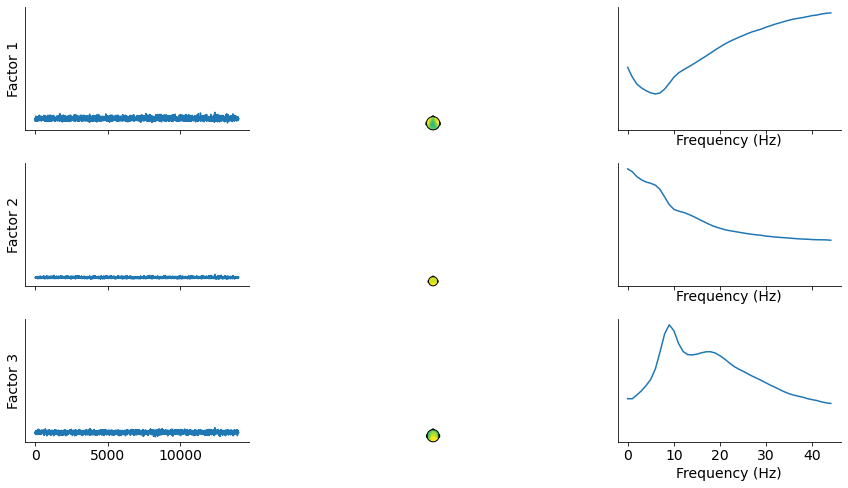

In [19]:
#visualize raw time series for factors 3 and 6 (high and low)
%matplotlib inline 
# plot the decomposed factors
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plot_factors(factors_orig, d=3)

In [20]:
# from tensortools.tensors import KTensor
# factors_list=[]
# for i in range(4):
#     #R=new_features.shape[0]
# #     freeze_weights= np.ones((R,))
# #     trans_psds1=trans_psds.swapaxes(0,2)
# #     new_features1=new_features.T
# #     freeze_factors= [new_features1,np.random.rand(trans_psds1.shape[1],R),np.random.rand(trans_psds1.shape[2],R)]
# # #     print(freeze_factors[0].shape,freeze_factors[1].shape,freeze_factors[2].shape)
# # #     print(new_features1.shape)
# # #     print(trans_psds.shape)
# # #     print(trans_psds1.shape)
# #     _,factors_tt=parafac(trans_psds1,rank=R,init=(freeze_weights,freeze_factors),fixed_modes=[0])
# #     factors_tt[0],factors_tt[2]=factors_tt[2],factors_tt[0]
#     #factors_orig=factors_tt
#     freeze_factors=KTensor([np.random.rand(factors_orig[0].shape[0],factors_orig[0].shape[1]),
#                     np.random.rand(factors_orig[1].shape[0],factors_orig[1].shape[1]),factors_orig[2]])
#     U= tt.ncp_hals(trans_psds,rank=R,init=freeze_factors,skip_modes=[2],verbose=False)
#     factors_tt=U.factors.factors
#     plot_factors(factors_tt)
#     X_hat=reconstruct(factors_tt)
#     fit_i=fit(trans_psds,X_hat)
#     print(fit_i)

## Comparision Across Seeds

In [21]:
# def comp_factors(factors1,factors2,spatial_index=1,frequency_index=2):
#     reconstruct_factors1=[]
#     reconstruct_factors2=[]
#     b1=factors1[spatial_index]
#     c1=factors1[frequency_index]
#     b2=factors2[spatial_index]
#     c2=factors2[frequency_index]
#     R=b2.shape[1]
#     for i in range(R):
#         reconstructed1= b1[:,i][...,np.newaxis]*c1[:,i][...,np.newaxis].T
#         reconstructed2= b2[:,i][...,np.newaxis]*c2[:,i][...,np.newaxis].T
#         reconstruct_factors1.append(reconstructed1)
#         reconstruct_factors2.append(reconstructed2)
#     matrix=np.zeros((R,R))
#     for i in range(R):
#         for j in range(R):
#             matrix[i][j]=np.linalg.norm(reconstruct_factors1[i]-reconstruct_factors2[j],ord="fro")
#     return matrix
# def comp_factors_list(factors_list,comparison_index=0):
#     comparison_factors=factors_list[comparison_index]
#     min_list=[]
#     for i in range(len(factors_list)):
#         print(i)
#         if i!=comparison_index:
#             matrix= comp_factors(comparison_factors,factors_list[i])
#             print(matrix)
#             min_values= np.min(matrix,axis=1)
#             min_list.append(min_values[...,np.newaxis])
#     min_list= np.concatenate(min_list,axis=1)
#     averages= np.mean(min_list,axis=1)[...,np.newaxis]
#     return averages
# factors_list1= [factors_orig]+factors_list
# print(comp_factors_list(factors_list1))

# '''
# Avg
# [[ 8.25918356]
#  [ 9.45101014]
#  [11.04906569]
#  [ 8.55704218]
#  [11.38017211]]
# '''

# '''
# All
# [[23.02710372]
#  [15.85229006]
#  [14.93993985]
#  [16.24510911]
#  [18.53251892]]
# '''

# '''
# Avg- Non negative
# [[ 9.86274231]
#  [11.12930193]
#  [ 7.03399529]
#  [ 7.47959891]
#  [11.00911253]]
# '''
# '''
# [[22.32272071]
#  [14.75347844]
#  [ 8.95201006]
#  [14.13821888]
#  [16.79494557]]
# '''

## TODO: write of describe logic somewhere (Done)

In [22]:
#Does comparison of factors across various seeds

'''
Here we describe the logic of the following code.

We started by using the fixed random seed to calculate a initial decomposition for four different cases:
no per subject averaging w/o non-negativity, per subject averaging w/o non-negativity, 
no per subject averaging w/ non-negativity, per subject averaging w/ non-negativity.
For each of the four cases we ran the tensor decompostion on the data five additional times.
We compared each factor of our initial decomposition to the each factor of each additional decomposition
using mean squared error and for each additional decomposition assigned that mse value to that factor in the
min array. After such computation,we average the mse for across each factor for each of the five additional
decompositions. The results are pictured in the table below.
'''


from tabulate import tabulate
factor_nums= np.array([[1],
[2],
[3],
[4],
[5]])
a=np.array([[ 8.25918356],
 [ 9.45101014],
 [11.04906569],
 [ 8.55704218],
 [11.38017211]])
b= np.array([[23.02710372],
 [15.85229006],
 [14.93993985],
 [16.24510911],
 [18.53251892]])
c=np.array([[ 9.86274231],
 [11.12930193],
 [ 7.03399529],
 [ 7.47959891],
 [11.00911253]])

d=np.array([[22.32272071],
 [14.75347844],
 [ 8.95201006],
 [14.13821888],
 [16.79494557]])

data=np.concatenate([factor_nums,a,b,c,d],axis=1)
head=["Factor #","Avg","All","Avg-NN","All-NN"]
print(tabulate(data, headers=head, tablefmt="grid"))

+------------+----------+---------+----------+----------+
|   Factor # |      Avg |     All |   Avg-NN |   All-NN |
+============+==========+=========+==========+==========+
|          1 |  8.25918 | 23.0271 |  9.86274 | 22.3227  |
+------------+----------+---------+----------+----------+
|          2 |  9.45101 | 15.8523 | 11.1293  | 14.7535  |
+------------+----------+---------+----------+----------+
|          3 | 11.0491  | 14.9399 |  7.034   |  8.95201 |
+------------+----------+---------+----------+----------+
|          4 |  8.55704 | 16.2451 |  7.4796  | 14.1382  |
+------------+----------+---------+----------+----------+
|          5 | 11.3802  | 18.5325 | 11.0091  | 16.7949  |
+------------+----------+---------+----------+----------+


## TODO: describe algorithm for reprojection (Done)

### project all data onto the space of factors

In [23]:
#Taking statistic of unlabeled data to be used on unseen data

'''
Here I briefly describe the mathematics behind the reprojection algorithm. 
The first of takes our original tensor and reshape it so that we get a two dimensional tensor.
In other words we reshape the tensor from (N, 19, 45) -> (N, 19x45) (where N is the number of subjects)
Similarly we construct a tensor from our recovered factors that is also two dimensional by taking the 
outer product of the spatial and frequency factors and concatenating.
This constructed tensor is of dimension (5,19x45)

To recover the projected spatial factors we take the reshaped original tensor and multiply it by
the pseudo inverse of the tensor constructed from our recovered factors. This tensor is of dimension 
(N, 5)
'''

trans_psds_full = (full_psds - psds_min) / (psds_max - psds_min)
psds_unrolled = np.reshape(trans_psds_full, [trans_psds_full.shape[0], -1])

factors_unrolled = []
for i in range(factors_orig[0].shape[1]):
    factors_unrolled.append(np.reshape(np.outer(factors_orig[1][:,i], factors_orig[2][:,i]), [-1]))
    
factor_ws = np.matmul(psds_unrolled, np.linalg.pinv(np.array(factors_unrolled)))

# factor_ws = factors_orig[0]
factor_ws.shape

(17052, 3)

## Only use unlabeled data?

### normal/abnormal grades - group level comparison across factors

['abnormal' 'abnormal' 'abnormal' ... 'normal' 'normal' 'normal']
Factor Normal: 0.060964916083783904
Factor Abnormal: 0.06446762911731736
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

abnormal v.s. normal: t-test independent samples with Bonferroni correction, P_val=3.546e-32 stat=1.184e+01
Ttest_indResult(statistic=-11.835918679119434, pvalue=3.5457184011408383e-32)
['abnormal' 'abnormal' 'abnormal' ... 'normal' 'normal' 'normal']
Factor Normal: 0.06959355684893725
Factor Abnormal: 0.08104500244291453
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

abnormal v.s. normal: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=6.940e+01
Ttest_indResult(statistic=-69.39580848373839, pvalue=0.0)
['abnormal' 'abnormal' 'abnormal' ... 'norm

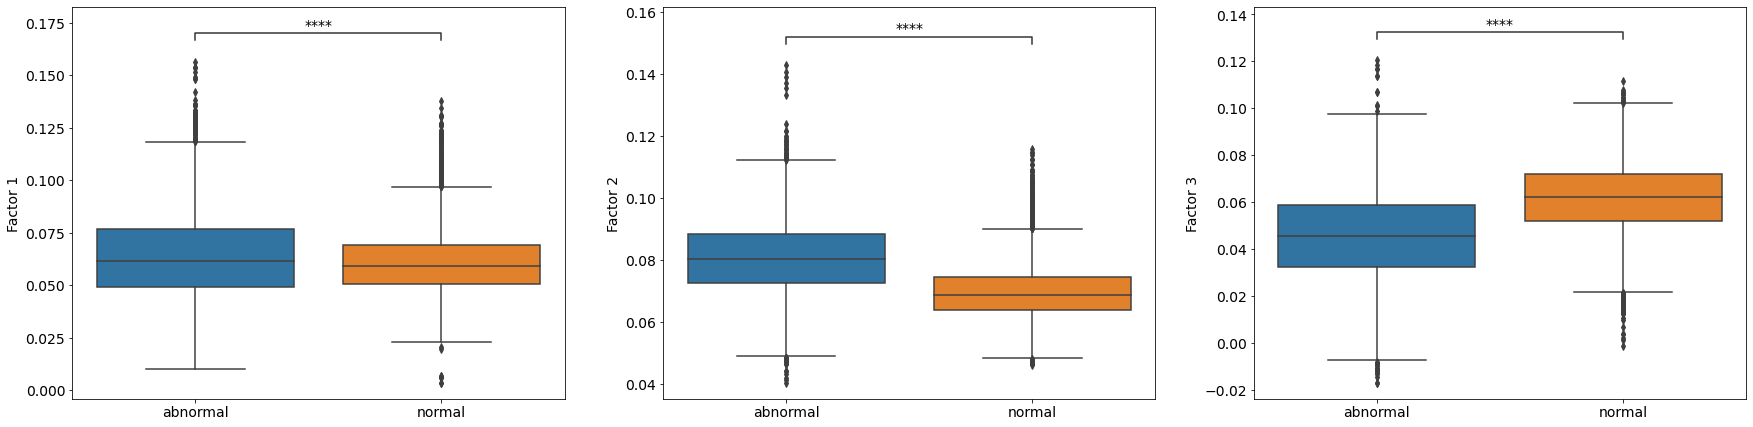

In [24]:
#Look at age distribution of normal versus abnormal patients (look at density estimation or bar plot)
from scipy.stats import kstest,ttest_ind
from scipy.stats import f_oneway
from statannot import add_stat_annotation

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
p_values=[]
fig, ax = plt.subplots(1,R, figsize=(30,7.2))
for i in range(R):
    x=grade[grade >=0]
    x=x.astype(str)
    x[x=='0']="normal"
    x[x=='1']="abnormal"
    y=factor_ws[grade >=0,i]
    df=pd.DataFrame()
    #print(x.shape, y.shape)
    df["abnormal"]= x
    df["factor"]=y
    sns.boxplot(x=x, y=y, ax=ax[i])
    print(x)
    print("Factor Normal:",np.mean(y[x=="normal"]))
    print("Factor Abnormal:",np.mean(y[x=="abnormal"]))
   # ax[i].set_xticks(np.arange(2), ['Normal', 'Abnormal'])

    #ax[i].set_xlabel("Label", {'fontsize' : 14})
    ax[i].set_ylabel(f"Factor {i+1}", {'fontsize' : 14})
    add_stat_annotation(ax[i],data=df, x="abnormal", y="factor", box_pairs=[("normal","abnormal")],test='t-test_ind', text_format='star')
    stat_test = ttest_ind(y[x=='normal'],y[x=='abnormal'])
    print(stat_test)
    p_values.append(stat_test.pvalue)
plt.show()

# p_values = np.array(p_values)
# x_pos = np.arange(len(p_values))+1
# bars=plt.bar(x_pos,p_values)
# xlocs,_=plt.xticks(x_pos)


# for i,bar in enumerate(bars):
#     yval = bar.get_height()
#     plt.text(bar.get_x()+bar.get_width()/2, yval + 0.5e-9, "*", horizontalalignment="center")
# plt.ylabel("P-value")
# plt.xlabel("Factor #")
# plt.show()


    

In [25]:
# # "Embedding" Plots of Tensor Decomposition Abnormal/Normal
an_grade = grade[grade>=0]
an_factor = factor_ws[grade>=0, :]
MAPPING_DIMENSION = 2
PERPLEXITY = 2
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=3,
                n_iter=EPOCHS
            ).fit_transform(an_factor)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 14922 samples in 0.008s...
[t-SNE] Computed neighbors for 14922 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14922
[t-SNE] Computed conditional probabilities for sample 2000 / 14922
[t-SNE] Computed conditional probabilities for sample 3000 / 14922
[t-SNE] Computed conditional probabilities for sample 4000 / 14922
[t-SNE] Computed conditional probabilities for sample 5000 / 14922
[t-SNE] Computed conditional probabilities for sample 6000 / 14922
[t-SNE] Computed conditional probabilities for sample 7000 / 14922
[t-SNE] Computed conditional probabilities for sample 8000 / 14922
[t-SNE] Computed conditional probabilities for sample 9000 / 14922
[t-SNE] Computed conditional probabilities for sample 10000 / 14922
[t-SNE] Computed conditional probabilities for sample 11000 / 14922
[t-SNE] Computed conditional probabilities for sample 12000 / 14922
[t-SNE] Computed conditional probabilities for samp

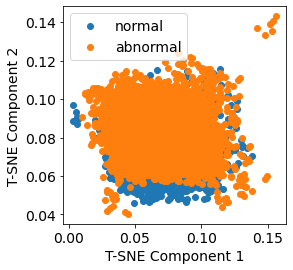

In [26]:
# "Embedding" Plots of Tensor Decomposition Abnormal/Normal
#print(subset_z_embed.shape)
an_grade = grade[grade>=0]
an_factor = factor_ws[grade>=0, :]
abnormal_labels = np.unique(an_grade)
abnormal_titles=["normal", "abnormal"]

for label in abnormal_labels:
    plt.scatter(an_factor[an_grade==label,0], an_factor[an_grade==label,1],label=abnormal_titles[label])
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend()

### Age

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 91 92 93 94 95]
Correlation Coefficent >30: [[1.         0.07871834]
 [0.07871834 1.        ]]
Correlation Coefficent: [[1.         0.08246142]
 [0.08246142 1.        ]]
3.8400995589089373e-31
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)]
3108 6150 5808 1986
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: t-test independent samples with Bonferroni correction, P_val=8.708e-18 stat=-8.791e+00
2 v.s. 3: t-test independent samples with Bonferroni correction, P_val=2.132e-02 stat=-2.859e+00
1 v.s. 3: t-test independent samples with Bonferroni correction, P_val=2.602e-28 stat=-1.122e+01
2 v.s. 4: t-test in

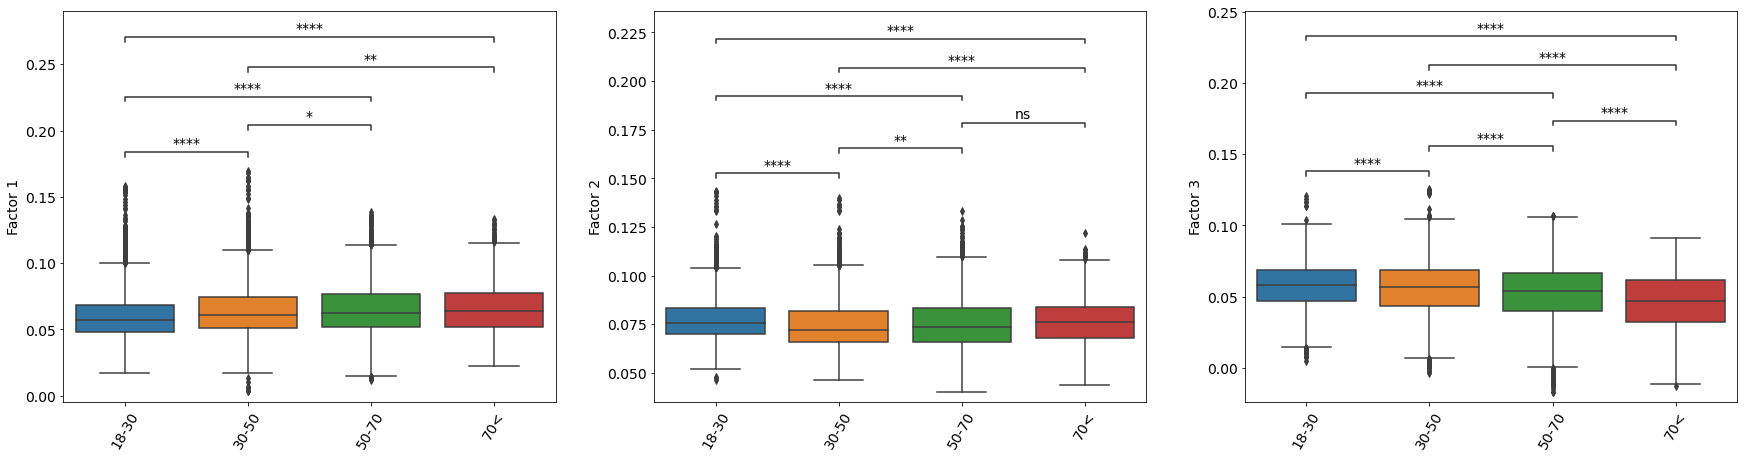

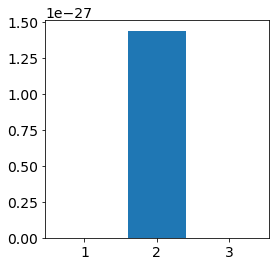

In [27]:
# Group level analysis of different age groups across factors
from scipy.stats import f_oneway
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
p_values = []
order = [1, 2, 3, 4]
permutations = []
for i in range(len(order)):
    for j in range(i+1,len(order)):
        permutations.append((order[i],order[j]))
print(permutations)
fig, ax = plt.subplots(1,R, figsize=(30,7.2))
print(np.unique(age))
for i in range(R):
    #fig, ax = plt.subplots(1,1)
    x = np.digitize(age, np.arange(10, 100, 20))
    filtered_age = age[(grade >= -1)]
    x[x==5] = 4
    x = x[(grade >= -1)]
    y = factor_ws[:,i]
    y = y[(grade >= -1)]
    sns.boxplot(x=x, y=y, ax=ax[i])
    print("Correlation Coefficent >30:", np.corrcoef(x[filtered_age<=70],y[filtered_age<=70]))
    print("Correlation Coefficent:", np.corrcoef(x,y))
    
    #plt.scatter(age, y)
    #plt.show()

    #plt.xticks(np.arange(5), ['18-30', '30-50', '50-70', '70-90', '>90'], rotation=60)
    df=pd.DataFrame()
    df["age"]= x
    df["factor"]=y
    ax[i].set_xticks(np.arange(4), ['18-30', '30-50', '50-70', '70<'], rotation=60)

    #ax[i].set_xlabel("Age Group", {'fontsize' : 14})
    ax[i].set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
    group_1= y[x==1]
    group_2= y[x==2]
    group_3= y[x==3]
    group_4= y[(x==4) | (x==5)]
    print(f_oneway(group_1,group_2,group_3,group_4).pvalue)
    box_pair=[]
    for permute in permutations:
        if ttest_ind(y[x==permute[0]],y[x==permute[1]]).pvalue<0.05:
            box_pair.append(permute)
    p_values.append(f_oneway(group_1,group_2,group_3,group_4).pvalue)
    print(box_pair)
    print(len(group_1),len(group_2),len(group_3),len(group_4))
    add_stat_annotation(ax[i],data=df, x="age", y="factor", box_pairs=box_pair,test='t-test_ind', text_format='star')
plt.show()
p_values = np.array(p_values)
x_pos = np.arange(len(p_values))+1
bars=plt.bar(x_pos,p_values)
xlocs,_=plt.xticks(x_pos)


# for i,bar in enumerate(bars):
#     if p_values[i]>0.05:
#         continue
        
#     yval = bar.get_height()
#     plt.text(bar.get_x()+bar.get_width()/2, yval + 0.5e-11, "*", horizontalalignment="center")
# plt.xlabel("Factor #")
# plt.ylabel("P-value")
# plt.show()

### Epilepsy subgroups

p-value (Anova-Test): 9.014861546973215e-40
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC v.s. PNES: t-test independent samples with Bonferroni correction, P_val=7.700e-20 stat=-9.672e+00
DRE v.s. NC: t-test independent samples with Bonferroni correction, P_val=9.194e-03 stat=3.131e+00
MRE v.s. DRE: t-test independent samples with Bonferroni correction, P_val=1.521e-24 stat=1.054e+01
MRE v.s. NC: t-test independent samples with Bonferroni correction, P_val=8.467e-17 stat=8.614e+00
DRE v.s. PNES: t-test independent samples with Bonferroni correction, P_val=3.208e-24 stat=-1.066e+01
p-value (Anova-Test): 1.5069593984761282e-136
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC v.s. PNES: t-test independent samples with Bonferroni correction, P_val=4.886e

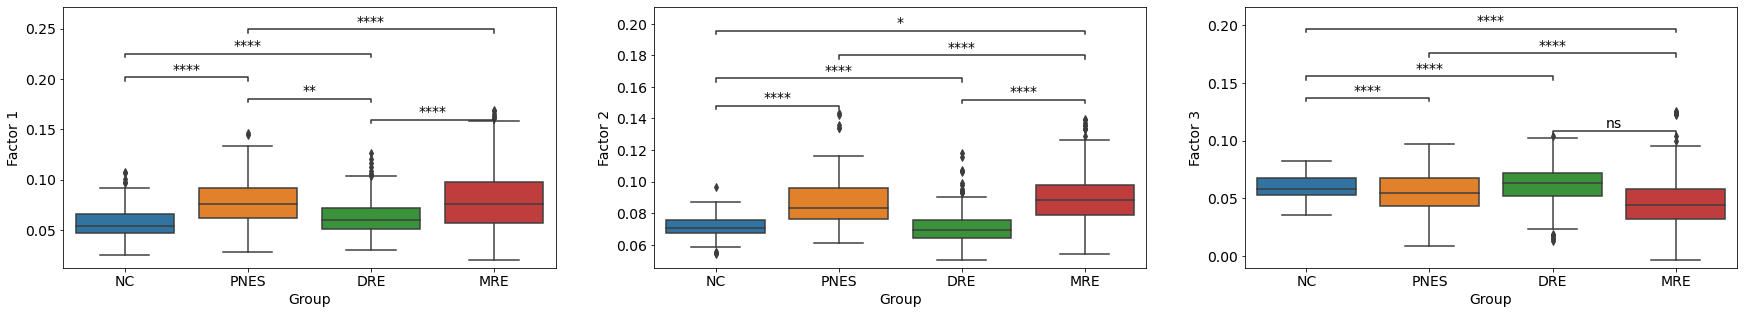

[[('NC', 'PNES'), ('NC', 'DRE'), ('NC', 'MRE'), ('PNES', 'DRE'), ('DRE', 'MRE')], [('NC', 'PNES'), ('NC', 'MRE'), ('PNES', 'DRE'), ('PNES', 'MRE'), ('DRE', 'MRE')], [('NC', 'PNES'), ('NC', 'MRE'), ('PNES', 'DRE'), ('PNES', 'MRE'), ('DRE', 'MRE')]]


In [28]:
from scipy.stats import f_oneway
from statannot import add_stat_annotation

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
p_values=[]
order = ['NC', 'PNES', 'DRE', 'MRE']
permutations = []
for i in range(len(order)):
    for j in range(i+1,len(order)):
        permutations.append((order[i],order[j]))
fig, ax = plt.subplots(1,R, figsize=(30,4.8))
box_pairs=[]
for i in range(R):
    box_pair=[]
    #fig, ax = plt.subplots(1,1)
    x=epi_dx[epi_dx>=0].astype(str)
    x[x=='0'] = 'NC'
    x[x=='1'] = 'PNES'
    x[x=='2'] = 'DRE'
    x[x=='3'] = 'MRE'
    y=factor_ws[epi_dx>=0,i]
    
    df=pd.DataFrame()
    df["epilepsy"]= x
    df["factor"]=y
    
    
    sns.boxplot(data=df,x="epilepsy", y="factor", order=order,ax=ax[i])
    
    #Include legend somewhere
    
    plt.xticks(np.arange(4), ['NC', 'PNES', 'DRE', 'MRE'])

    ax[i].set_xlabel("Group", {'fontsize' : 14})
    ax[i].set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
    NC_group=y[x=='NC']
    PNES_group=y[x=='PNES']
    DRE_group=y[x=='DRE']
    MRE_group=y[x=='MRE']
    for permute in permutations:
        if ttest_ind(y[x==permute[0]],y[x==permute[1]]).pvalue<0.05:
            box_pair.append(permute)
    box_pairs.append(box_pair)
    print("p-value (Anova-Test):", f_oneway(NC_group,PNES_group,DRE_group,MRE_group).pvalue) 
    p_values.append(f_oneway(NC_group,PNES_group,DRE_group,MRE_group).pvalue)
    add_stat_annotation(ax[i],data=df, x="epilepsy", y="factor", box_pairs=box_pair,test='t-test_ind', text_format='star')
plt.show()
print(box_pairs)


In [29]:
epi_grade = epi_dx[epi_dx>=0]
epi_factor = factor_ws[epi_dx>=0, :]
MAPPING_DIMENSION = 2
PERPLEXITY = 50
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=3,
                n_iter=EPOCHS
            ).fit_transform(epi_factor)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2370 samples in 0.001s...
[t-SNE] Computed neighbors for 2370 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2370
[t-SNE] Computed conditional probabilities for sample 2000 / 2370
[t-SNE] Computed conditional probabilities for sample 2370 / 2370
[t-SNE] Mean sigma: 0.005710
[t-SNE] Computed conditional probabilities in 0.096s
[t-SNE] Iteration 50: error = 71.7904434, gradient norm = 0.0871619 (50 iterations in 0.334s)
[t-SNE] Iteration 100: error = 65.3068695, gradient norm = 0.0025731 (50 iterations in 0.331s)
[t-SNE] Iteration 150: error = 65.2494736, gradient norm = 0.0005095 (50 iterations in 0.294s)
[t-SNE] Iteration 200: error = 65.2486572, gradient norm = 0.0005247 (50 iterations in 0.351s)
[t-SNE] Iteration 250: error = 65.2490082, gradient norm = 0.0003270 (50 iterations in 0.401s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.249008
[t-SNE] Iteration 300: err

Text(0, 0.5, 'T-SNE Component 2')

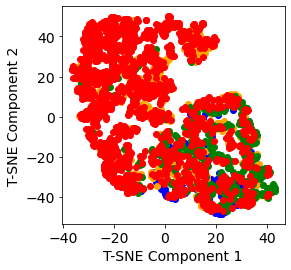

In [30]:
# "Embedding" Plots of Tensor Decomposition Epilepy
epi_grade = epi_dx[epi_dx>=0]
epi_factor = factor_ws[epi_dx>=0, :]
epi_labels = np.unique(epi_grade)
epi_titles=['NC', 'PNES', 'DRE', 'MRE']

colors = ["blue","orange", "green", "red"]
for label in epi_labels:
#     if label==3:
#         continue
    plt.scatter(subset_z_embed[epi_grade==label,0], subset_z_embed[epi_grade==label,1],label=epi_titles[label], 
                color=colors[label])
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
#plt.legend()

Text(0, 0.5, 'Factor 5')

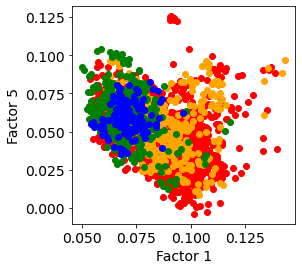

In [31]:
# "Embedding" Plots of Tensor Decomposition Epilepy
epi_grade = epi_dx[epi_dx>=0]
epi_factor = factor_ws[epi_dx>=0, :]
epi_labels = np.unique(epi_grade)
epi_labels = np.array([3,1,2,0])#epi_labels[::-1]
epi_titles=['NC', 'PNES', 'DRE', 'MRE']

colors = ["blue","orange", "green", "red"]
for label in epi_labels:
#     if label==3:
#         continue
    plt.scatter(epi_factor[epi_grade==label,1], epi_factor[epi_grade==label,2],label=epi_titles[label], 
                color=colors[label])
plt.xlabel("Factor 1")
plt.ylabel("Factor 5")
#plt.legend()

### Alzheimer's Vs normal

51 89 41 90 47 93
p-value (ANOVA-Test): 0.2790712122913879
[('CN', 'AD'), ('MCI', 'AD')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CN v.s. AD: t-test independent samples with Bonferroni correction, P_val=7.637e-04 stat=-3.580e+00
MCI v.s. AD: t-test independent samples with Bonferroni correction, P_val=1.470e-06 stat=-5.018e+00


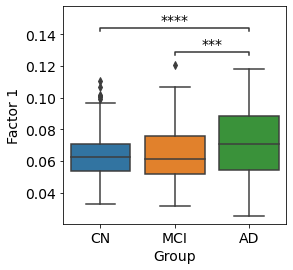

51 89 41 90 47 93
p-value (ANOVA-Test): 0.0011575256145626887
[('CN', 'MCI'), ('CN', 'AD'), ('MCI', 'AD')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI v.s. CN: t-test independent samples with Bonferroni correction, P_val=3.473e-03 stat=3.278e+00
CN v.s. AD: t-test independent samples with Bonferroni correction, P_val=5.735e-39 stat=-1.455e+01
MCI v.s. AD: t-test independent samples with Bonferroni correction, P_val=2.408e-30 stat=-1.239e+01


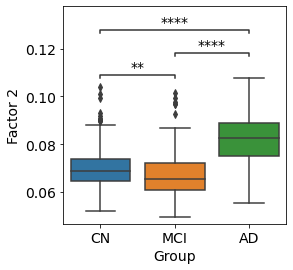

51 89 41 90 47 93
p-value (ANOVA-Test): 0.004578072553055068
[('CN', 'MCI'), ('CN', 'AD'), ('MCI', 'AD')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI v.s. CN: t-test independent samples with Bonferroni correction, P_val=1.373e-02 stat=-2.855e+00
CN v.s. AD: t-test independent samples with Bonferroni correction, P_val=7.547e-32 stat=1.285e+01
MCI v.s. AD: t-test independent samples with Bonferroni correction, P_val=9.728e-15 stat=8.145e+00


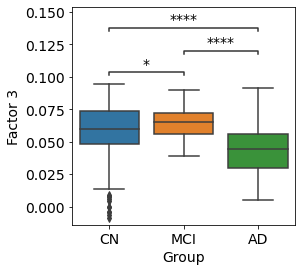

In [32]:
from scipy.stats import f_oneway
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14

order = ['CN', 'MCI', 'AD']
permutations = []
for i in range(len(order)):
    for j in range(i+1,len(order)):
        permutations.append((order[i],order[j]))

box_pairs=[]
#fig, ax = plt.subplots(1,R, figsize=(30,4.8))
for i in range(R):
    box_pair=[]
    fig, ax = plt.subplots(1,1)
    print(np.min(age[alz_dx==0]), np.max(age[alz_dx==0]), np.min(age[alz_dx==1]), np.max(age[alz_dx==1]), np.min(age[alz_dx==2]), np.max(age[alz_dx==2]))
    x=alz_dx[alz_dx>=0].astype(str)
    x[x=='0'] = 'CN'
    x[x=='1'] = 'MCI'
    x[x=='2'] = 'AD'
    y=factor_ws[alz_dx>=0,i]
    
    df=pd.DataFrame()
    df["alzheimers"]= x
    df["factor"]=y
    
    sns.boxplot(data=df, x="alzheimers", y="factor", ax=ax)

    plt.xticks(np.arange(3), ['CN', 'MCI', 'AD'])
    CN_group= y[x=="CN"]
    MCI_group= y[x=="MCI"]
    AD_group= y[x=="AD"]
    print("p-value (ANOVA-Test):",f_oneway(CN_group,MCI_group).pvalue)
    for permute in permutations:
        if ttest_ind(y[x==permute[0]],y[x==permute[1]]).pvalue<=0.05:
            box_pair.append(permute)
    box_pairs.append(box_pair)
    p_values.append(f_oneway(NC_group,PNES_group,DRE_group,MRE_group).pvalue)
    print(box_pair)
    add_stat_annotation(ax,data=df, x="alzheimers", y="factor", box_pairs=box_pair,test='t-test_ind', text_format='star')

    ax.set_xlabel("Group", {'fontsize' : 14})
    ax.set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
    plt.show()

In [33]:
alz_grade = alz_dx[epi_dx>=0]
alz_factor = factor_ws[alz_dx>=0, :]
MAPPING_DIMENSION = 2
PERPLEXITY = 100
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=3,
                n_iter=EPOCHS
            ).fit_transform(alz_factor)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 630 samples in 0.000s...
[t-SNE] Computed neighbors for 630 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 630 / 630
[t-SNE] Mean sigma: 0.011169
[t-SNE] Computed conditional probabilities in 0.051s
[t-SNE] Iteration 50: error = 51.4551620, gradient norm = 0.3989672 (50 iterations in 0.093s)
[t-SNE] Iteration 100: error = 51.8042831, gradient norm = 0.3926832 (50 iterations in 0.145s)
[t-SNE] Iteration 150: error = 51.5831909, gradient norm = 0.3875849 (50 iterations in 0.109s)
[t-SNE] Iteration 200: error = 51.2301178, gradient norm = 0.3865398 (50 iterations in 0.171s)
[t-SNE] Iteration 250: error = 51.0693283, gradient norm = 0.3989899 (50 iterations in 0.132s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.069328
[t-SNE] Iteration 300: error = 0.3526229, gradient norm = 0.0008740 (50 iterations in 0.147s)
[t-SNE] Iteration 350: error = 0.3498610, gradient norm = 0.0001551 

Text(0, 0.5, 'T-SNE Component 2')

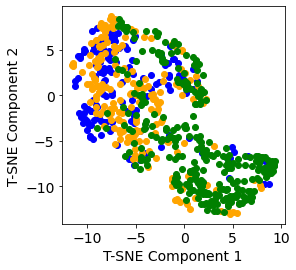

In [34]:
# "Embedding" Plots of Tensor Decomposition Alzheimer's
alz_grade = alz_dx[alz_dx>=0]
alz_factor = factor_ws[alz_dx>=0, :]
alz_labels = np.unique(alz_grade)
alz_titles=["CN", "MCI", "AD"]
colors=["blue","orange", "green"]
for label in alz_labels:
    plt.scatter(subset_z_embed[alz_grade==label,0], subset_z_embed[alz_grade==label,1],label=alz_titles[label], 
                color=colors[label])
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
#plt.legend()

Text(0, 0.5, 'Factor 5')

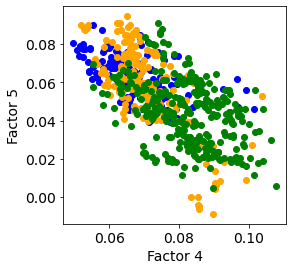

In [35]:
# "Embedding" Plots of Tensor Decomposition Alzheimer's
alz_grade = alz_dx[alz_dx>=0]
alz_factor = factor_ws[alz_dx>=0, :]
alz_labels = np.unique(alz_grade)
alz_titles=["CN", "MCI", "AD"]
colors=["blue","orange", "green"]
for label in alz_labels:
    plt.scatter(alz_factor[alz_grade==label,1], alz_factor[alz_grade==label,2],label=alz_titles[label], 
                color=colors[label])
plt.xlabel("Factor 4")
plt.ylabel("Factor 5")
#plt.legend()

### Seizure hemisphere analysis

In [36]:
# plt.rcParams["figure.figsize"] = (4,4)
# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14
# plt.rcParams['legend.fontsize'] = 14
# plt.rcParams['font.size'] = 14
# fig, ax = plt.subplots(1,1)

# sns.boxplot(x=sz_side[(handed==0) & (sz_side>=0)], y=factor_ws[(handed==0) & (sz_side>=0),0], ax=ax)

# plt.xticks(np.arange(2), ['Right-SOZ', 'Left-SOZ'])

# ax.set_xlabel("Seizure Hemisphere", {'fontsize' : 14})
# ax.set_ylabel("Posterior Alpha", {'fontsize' : 14})
# plt.show()

In [37]:
#subject factors for all data
np.save("factor_ws.npy",factor_ws)
#epilepsy data
np.save("epi_dx.npy", epi_dx)
#alzheimer's dementia data
np.save("alz_dx.npy", alz_dx)

## TODO: Save dataframe (Done)

In [38]:
DATA_DIR= "/home/teja/tensor_decomposition_new/data"
column_names = ['F'+str(i) for i in range(1, factors_orig[0].shape[1]+1)]
df = pd.DataFrame(data=factor_ws, columns=column_names)
df['PID'] = pids
df['SID'] = sids
df['CID'] = cids
df['Age'] = age
df['Grade'] = grade
df['Gender'] = gender
df['Handedness'] = handed
df['Epilepsy'] = epi_dx
df['Alzheimers'] = alz_dx
#df['psds'] = full_psds

df = df.sort_values(['PID', 'SID', 'CID'])
print(len(df))

df.to_csv(op.join(DATA_DIR,"tensor_decomposition_df.csv"))

17052


In [39]:
print(df.groupby(['PID']).first()['Alzheimers'].value_counts())
print(df.groupby(['PID']).first()['Epilepsy'].value_counts())

-1    2059
 2      32
 1      30
 0      24
Name: Alzheimers, dtype: int64
-1    1992
 3      59
 2      50
 0      23
 1      21
Name: Epilepsy, dtype: int64


In [40]:
import statsmodels.api as sm # import statsmodels 

X = df[column_names]
y = df["Age"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     316.0
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          1.15e-199
Time:                        20:36:53   Log-Likelihood:                -72089.
No. Observations:               17052   AIC:                         1.442e+05
Df Residuals:                   17048   BIC:                         1.442e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.4061      1.318     54.935      0.000      69.823      74.990
F1            40.2928      6.741      5.978      0.000      27.080      53.505
F2          -193.2681     11.997    -16.110      0.000    -216.784    -169.753
F3          -230.7260      8.267    -27.911      0.000    -246.929    -214.523
==============================================================================
Omnibus:                      736.197   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.158
Skew:                           0.214   Prob(JB):                     2.85e-88
Kurtosis:                       2.380   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Classification

In [41]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_fscore_support,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [42]:
from copy import deepcopy
import pickle
import os
MODEL_DIR = "/home/teja/tensor_decomposition_new/saved_models/"
def classify_LOO(features, labels, clf= GaussianNB(), adjust_sampling_weight=False, save_model= False, save_model_name="None"):

    #clf = GaussianNB()
    clfs=[]
    kf = LeaveOneOut()
    all_y = []
    all_probs=[]
    for train, test in kf.split(features, labels):
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train]==0), 1:1./np.sum(labels[train]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train])
            fit_model = clf.fit(features[train], labels[train], sample_weight=sample_weight)
            clfs.append(deepcopy(clf))
        else:
            fit_model = clf.fit(features[train], labels[train])
            clfs.append(deepcopy(clf))
        all_y.append(labels[test])
        all_probs.append(fit_model.predict_proba(features[test])[:,1])
        #print(fit_model.predict_proba(features[test]))
    all_y = np.concatenate(all_y)
    all_probs = np.concatenate(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,saved_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

def classify_Strat(features, labels, clf= GaussianNB(), adjust_sampling_weight=False, folds=15, save_model= False, save_model_name="None"):

    #clf = GaussianNB()
    clfs=[]
    kf = StratifiedKFold(folds)

    all_y = []
    all_probs=[]
    
    auc_scores=[]

    for train, test in kf.split(features, labels):
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train]==0), 1:1./np.sum(labels[train]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train])
            fit_model = clf.fit(features[train], labels[train], sample_weight=sample_weight)
            clfs.append(deepcopy(fit_model))
        else:
            fit_model = clf.fit(features[train], labels[train])
            clfs.append(deepcopy(fit_model))
        all_y.append(labels[test])
        all_probs.append(fit_model.predict_proba(features[test])[:,1])
        try:
            auc_scores.append(roc_auc_score(all_y[-1], all_probs[-1]))
        except:
            pass
    print("AUC Mean:",np.mean(auc_scores))
    print("AUC Std:", np.std(auc_scores))
    all_y = np.concatenate(all_y)
    all_probs = np.concatenate(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,save_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

In [43]:
def plot_ROC(ax, all_y, all_probs, title):
    
    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MC-LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

### Epilepsy

In [44]:
# epilepsy_df = df.copy()[df['Epilepsy']>=0]
cls_df = df.copy()#.groupby(['PID']).mean()
epilepsy_df = cls_df.copy()[cls_df['Epilepsy']>=0]

epilepsy_df['PNES_vs_all'] = (epilepsy_df['Epilepsy'] == 1).astype(int)
epilepsy_df['DRE_vs_all'] = (epilepsy_df['Epilepsy'] == 2).astype(int)
epilepsy_df['MRE_vs_all'] = (epilepsy_df['Epilepsy'] == 3).astype(int)

all_pnes = {}
all_dre = {}
all_mre = {}
all_mre_pnes = {}

## TODO: Try to write use ROC Curve to compute thresholds for accuracy and compute balanced accuracy (sklearn) (Done)

In [45]:
import numpy as np
from sklearn.metrics import roc_curve

def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

## TODO: Add sample weight (inverse to class count)? or use "balanced" parameters? Search Neeraj's repos for class weight.

## TODO: new version of classify_LOO to return all metrics and thresholds

## TODO: figure out why AUC goes below 0.5

## TODO: revist user warnings

## TODO: For NN look at LR, Solver and weighting classes

## TODO: May need to tune hyperparameters

## Epilepsy TD naive Bayes

In [46]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

#PNES vs NC
sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['PNES_vs_all'].values
print(labels.shape)
y_pnes, probs_pnes = classify_Strat(features, labels, adjust_sampling_weight=True)
all_pnes["y_td_gb"] = y_pnes
all_pnes["probs_td_gb"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

#DRE vs NC
sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['DRE_vs_all'].values
print(labels.shape)
y_dre, probs_dre = classify_Strat(features, labels, adjust_sampling_weight=True)
all_dre["y_td_gb"] = y_dre
all_dre["probs_td_gb"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

#MRE vs NC
sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
print(labels.shape)
y_mre, probs_mre = classify_Strat(features, labels, adjust_sampling_weight=True)
all_mre["y_td_gb"] = y_mre
all_mre["probs_td_gb"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

#MRE vs PNES
sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
print(labels.shape)
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels, adjust_sampling_weight=True)
all_mre_pnes["y_td_gb"] = y_mre_pnes
all_mre_pnes["probs_td_gb"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# (48,)
# PNES vs NC (ACC = 0.75)
# PNES vs NC (Bal. ACC = 0.75)
# (84,)
# DRE vs NC (ACC = 0.64)
# DRE vs NC (Bal. ACC = 0.61)
# (107,)
# MRE vs NC (ACC = 0.75)
# MRE vs NC (Bal. ACC = 0.81)
# (109,)
# MRE vs PNES (ACC = 0.75)
# MRE vs PNES (Bal. ACC = 0.75)


(48,)
AUC Mean: 0.8
AUC Std: 0.3055050463303894
PNES vs NC (ACC = 0.75)
PNES vs NC (Bal. ACC = 0.75)
(84,)
AUC Mean: 0.6916666666666667
AUC Std: 0.2733536577809454
DRE vs NC (ACC = 0.58)
DRE vs NC (Bal. ACC = 0.63)
(107,)
AUC Mean: 0.8066666666666668
AUC Std: 0.2198315853691774
MRE vs NC (ACC = 0.77)
MRE vs NC (Bal. ACC = 0.80)
(109,)
AUC Mean: 0.5211111111111112
AUC Std: 0.26418755029031
MRE vs PNES (ACC = 0.70)
MRE vs PNES (Bal. ACC = 0.70)


In [47]:
# print(len(y_pnes))
# print(len(probs_pnes))

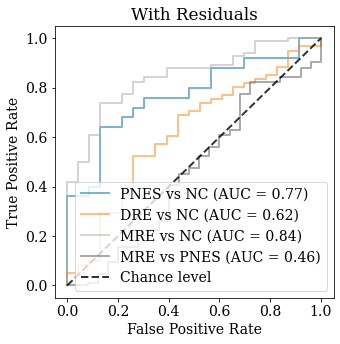

In [48]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy TD SVM

In [49]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['PNES_vs_all'].values
y_pnes, probs_pnes = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_pnes["y_td_gb"] = y_pnes
all_pnes["probs_td_gb"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['DRE_vs_all'].values
y_dre, probs_dre = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_dre["y_td_gb"] = y_dre
all_dre["probs_td_gb"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre, probs_mre = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_mre["y_td_gb"] = y_mre
all_mre["probs_td_gb"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_mre_pnes["y_td_gb"] = y_mre_pnes
all_mre_pnes["probs_td_gb"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.77)
# PNES vs NC (Bal. ACC = 0.78)
# DRE vs NC (ACC = 0.60)
# DRE vs NC (Bal. ACC = 0.63)
# MRE vs NC (ACC = 0.75)
# MRE vs NC (Bal. ACC = 0.81)
# MRE vs PNES (ACC = 0.24)
# MRE vs PNES (Bal. ACC = 0.24)


AUC Mean: 0.7666666666666667
AUC Std: 0.3091206165165235
PNES vs NC (ACC = 0.75)
PNES vs NC (Bal. ACC = 0.76)
AUC Mean: 0.6616666666666667
AUC Std: 0.24931015935086873
DRE vs NC (ACC = 0.63)
DRE vs NC (Bal. ACC = 0.64)
AUC Mean: 0.8400000000000002
AUC Std: 0.21088877180654755
MRE vs NC (ACC = 0.78)
MRE vs NC (Bal. ACC = 0.83)
AUC Mean: 0.46555555555555556
AUC Std: 0.2701485645225239
MRE vs PNES (ACC = 0.23)
MRE vs PNES (Bal. ACC = 0.23)


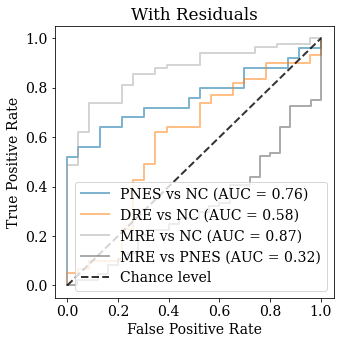

In [50]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## TODO: add early stopping for all MLP classifiers and figure out how to balance classes. Investigate sklearn NN further.

## Epilepsy TD NN

In [51]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['PNES_vs_all'].values
y_pnes, probs_pnes = classify_Strat(features, labels,clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_pnes["y_td_gb"] = y_pnes
all_pnes["probs_td_gb"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['DRE_vs_all'].values
y_dre, probs_dre = classify_Strat(features, labels,clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_dre["y_td_gb"] = y_dre
all_dre["probs_td_gb"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre, probs_mre = classify_Strat(features, labels,clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_mre["y_td_gb"] = y_mre
all_mre["probs_td_gb"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_df = epilepsy_df[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels,clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_mre_pnes["y_td_gb"] = y_mre_pnes
all_mre_pnes["probs_td_gb"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.60)
# PNES vs NC (Bal. ACC = 0.61)
# DRE vs NC (ACC = 0.69)
# DRE vs NC (Bal. ACC = 0.57)
# MRE vs NC (ACC = 0.70)
# MRE vs NC (Bal. ACC = 0.57)
# MRE vs PNES (ACC = 0.43)
# MRE vs PNES (Bal. ACC = 0.43)


AUC Mean: 0.45
AUC Std: 0.4301162633521314
PNES vs NC (ACC = 0.58)
PNES vs NC (Bal. ACC = 0.59)
AUC Mean: 0.575
AUC Std: 0.24494897427831783
DRE vs NC (ACC = 0.62)
DRE vs NC (Bal. ACC = 0.58)
AUC Mean: 0.6233333333333334
AUC Std: 0.3371888140141904
MRE vs NC (ACC = 0.66)
MRE vs NC (Bal. ACC = 0.56)
AUC Mean: 0.5222222222222223
AUC Std: 0.23425742935897798
MRE vs PNES (ACC = 0.66)
MRE vs PNES (Bal. ACC = 0.66)


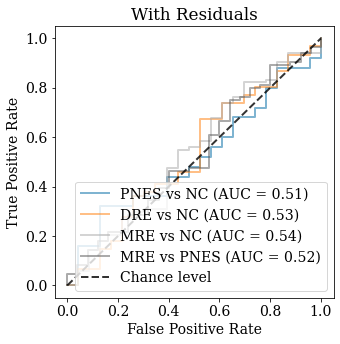

In [52]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## TODO: Compute band power with Welsh instead of FOOOF

## Epilepsy PSD

In [53]:
combined_psds = np.reshape(full_psds, [-1, 45])
spectra = 10 ** combined_psds
freqs = np.arange(1, 46)

list_psds = [10 ** full_psds[i] for i in range(full_psds.shape[0])]

In [54]:
from scipy.integrate import simps

def compute_welsh_single(spectra):
    lows = [1,4,8,13,25]
    highs = [4,8,13,25,45]
    freq_range = [1, 45]
    freqs = np.arange(freq_range[0], freq_range[1]+1)
    freq_res = freqs[1] - freqs[0]
    bps = []
    for i in range(len(lows)):
        low = lows[i]
        high = highs[i]
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp = simps(spectra[:,idx_band], dx=freq_res)
        bp /= simps(spectra[:], dx=freq_res)
        bps.append(bp)
    
    return {"delta_pow":bps[0], "theta_pow":bps[1], "alpha_pow": bps[2],
           "beta_pow":bps[3], "gamma_pow":bps[4]}

In [55]:
def compute_fooof_single(spectra):
    
    # Initialize a FOOOFGroup object, with desired settings
    fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.15,
                    peak_threshold=2., max_n_peaks=6, verbose=False)

    # Define the frequency range to fit
    freq_range = [1, 45]

    # Fit the power spectrum model across all channels
    fg.fit(freqs, spectra, freq_range)
    
    cfs = fg.get_params('peak_params', 'CF')
    exps = fg.get_params('aperiodic_params', 'exponent')
    
    delta_pow = get_band_peak_fg(fg, [1, 4])[:, 1]
    theta_pow = get_band_peak_fg(fg, [4, 8])[:, 1] ## (each row is [CF, PW, BW])
    alpha_pow = get_band_peak_fg(fg, [8, 13])[:, 1]
    beta_pow = get_band_peak_fg(fg, [13, 25])[:, 1]
    gamma_pow= get_band_peak_fg(fg, [25, 45])[:, 1]
    
    return {'cfs': cfs, 'exps': exps,'delta_pow':delta_pow ,
            'theta_pow': theta_pow, 'alpha_pow': alpha_pow, 'beta_pow': beta_pow, 'gamma_pow':gamma_pow}

In [56]:
with Executor(max_workers=30) as executor:
    results = [res for i,res in zip(list_psds, executor.map(compute_welsh_single, list_psds))]

In [57]:
delta_pows=[]
theta_pows=[]
alpha_pows=[]
beta_pows=[]
gamma_pows=[]

for i in range(len(results)):
    delta_pows.append(results[i]['delta_pow'].reshape(1,-1))
    theta_pows.append(results[i]['theta_pow'].reshape(1,-1))
    alpha_pows.append(results[i]['alpha_pow'].reshape(1,-1))
    beta_pows.append(results[i]['beta_pow'].reshape(1,-1))
    gamma_pows.append(results[i]['gamma_pow'].reshape(1,-1))
delta_pows=np.concatenate(delta_pows)
theta_pows=np.concatenate(theta_pows)
alpha_pows=np.concatenate(alpha_pows)
beta_pows=np.concatenate(beta_pows)
gamma_pows=np.concatenate(gamma_pows)

band_pows= np.concatenate([delta_pows, theta_pows, alpha_pows, beta_pows, gamma_pows],axis=1)
print(band_pows.shape)
np.save("/home/teja/tensor_decomposition_new/data/welsh_band_pows.npy", band_pows)


(17052, 95)


## TODO: Mention these are fooof band powers somewhere

In [58]:
band_pows=np.load("/home/teja/tensor_decomposition_new/data/welsh_band_pows.npy", allow_pickle=True)
print(band_pows.shape)

(17052, 95)


In [59]:
band_pows= pd.DataFrame(band_pows)
band_pows=band_pows.fillna(0)
band_pows['PID']=epilepsy_df['PID']
epilepsy_psds= band_pows.copy()[cls_df['Epilepsy']>=0]

epilepsy_psds['PNES_vs_all']= (epilepsy_df['Epilepsy'] == 1).astype(int)
epilepsy_psds['DRE_vs_all']= (epilepsy_df['Epilepsy'] == 2).astype(int)
epilepsy_psds['MRE_vs_all']= (epilepsy_df['Epilepsy'] == 3).astype(int)
# #PNES vs all
# pnes_label = (epilepsy_df['Epilepsy'] == 1).astype(int)
# #DRE vs all
# dre_label = (epilepsy_df['Epilepsy'] == 2).astype(int)
# #MRE vs all
# mre_label = (epilepsy_df['Epilepsy'] == 3).astype(int)

/tmp/ipykernel_2233240/4028183503.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  epilepsy_psds= band_pows.copy()[cls_df['Epilepsy']>=0]


## TODO: Check perplexity values

/tmp/ipykernel_2233240/1443242029.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ).fit_transform(band_pows[cls_df['Epilepsy']>=0])


(2370, 2)


Text(0, 0.5, 'TSNE Factor 2')

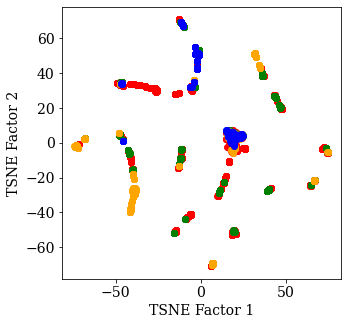

In [60]:
MAPPING_DIMENSION = 2
PERPLEXITY = 50
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=0,
                n_iter=EPOCHS
            ).fit_transform(band_pows[cls_df['Epilepsy']>=0])
print(subset_z_embed.shape)
epi_titles=['NC', 'PNES', 'DRE', 'MRE']
colors = ["blue","orange", "green", "red"]
for i in range(3,-1,-1):
    sub= subset_z_embed[epilepsy_df["Epilepsy"]==i]
    plt.scatter(sub[:,0],sub[:,1],label=epi_titles[i], color=colors[i])
plt.xlabel("TSNE Factor 1")
plt.ylabel("TSNE Factor 2")
#plt.legend()

## Epilepsy PSD (Gaussian Naive Bayes)

In [61]:
used_factors=np.arange(95)
sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['PNES_vs_all'].values
y_pnes, probs_pnes = classify_Strat(features, labels, adjust_sampling_weight=True)
all_pnes["y_psd_gb"] = y_pnes
all_pnes["probs_psd_gb"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['DRE_vs_all'].values
y_dre, probs_dre = classify_Strat(features, labels, adjust_sampling_weight=True)
all_dre["y_psd_gb"] = y_dre
all_dre["probs_psd_gb"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre, probs_mre = classify_Strat(features, labels, adjust_sampling_weight=True)
all_mre["y_psd_gb"] = y_mre
all_mre["probs_psd_gb"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels, adjust_sampling_weight=True)
all_mre_pnes["y_psd_gb"] = y_mre_pnes
all_mre_pnes["probs_psd_gb"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.71)
# PNES vs NC (Bal. ACC = 0.71)
# DRE vs NC (ACC = 0.69)
# DRE vs NC (Bal. ACC = 0.62)
# MRE vs NC (ACC = 0.75)
# MRE vs NC (Bal. ACC = 0.81)
# MRE vs PNES (ACC = 0.72)
# MRE vs PNES (Bal. ACC = 0.72)

AUC Mean: 0.55
AUC Std: 0.4301162633521314
PNES vs NC (ACC = 0.71)
PNES vs NC (Bal. ACC = 0.71)
AUC Mean: 0.6525
AUC Std: 0.28969092725408807
DRE vs NC (ACC = 0.69)
DRE vs NC (Bal. ACC = 0.62)
AUC Mean: 0.8116666666666668
AUC Std: 0.20900558206261702
MRE vs NC (ACC = 0.75)
MRE vs NC (Bal. ACC = 0.81)
AUC Mean: 0.5972222222222221
AUC Std: 0.31001294278039104
MRE vs PNES (ACC = 0.72)
MRE vs PNES (Bal. ACC = 0.72)


/tmp/ipykernel_2233240/3936866751.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
/tmp/ipykernel_2233240/3936866751.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
/tmp/ipykernel_2233240/3936866751.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
/tmp/ipykernel_2233240/3936866751.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]


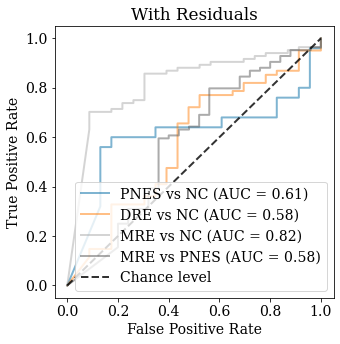

In [62]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy PSD (Classical Machine Learning)

In [63]:
used_factors=np.arange(95)
sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['PNES_vs_all'].values
y_pnes, probs_pnes = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_pnes["y_psd_svm"] = y_pnes
all_pnes["probs_psd_svm"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['DRE_vs_all'].values
y_dre, probs_dre = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_dre["y_psd_svm"] = y_dre
all_dre["probs_psd_svm"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre, probs_mre = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_mre["y_psd_svm"] = y_mre
all_mre["probs_psd_svm"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))
all_mre_pnes["y_psd_svm"] = y_mre_pnes
all_mre_pnes["probs_psd_svm"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.73)
# PNES vs NC (Bal. ACC = 0.74)
# DRE vs NC (ACC = 0.27)
# DRE vs NC (Bal. ACC = 0.50)
# MRE vs NC (ACC = 0.71)
# MRE vs NC (Bal. ACC = 0.77)
# MRE vs PNES (ACC = 0.24)
# MRE vs PNES (Bal. ACC = 0.24)

/tmp/ipykernel_2233240/1941916649.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]


AUC Mean: 0.8
AUC Std: 0.24494897427831785
PNES vs NC (ACC = 0.73)
PNES vs NC (Bal. ACC = 0.74)
AUC Mean: 0.305
AUC Std: 0.2463398736163785
DRE vs NC (ACC = 0.27)
DRE vs NC (Bal. ACC = 0.50)
AUC Mean: 0.8344444444444445
AUC Std: 0.20909564236090855
MRE vs NC (ACC = 0.73)
MRE vs NC (Bal. ACC = 0.78)
AUC Mean: 0.31666666666666665
AUC Std: 0.31896824409451907
MRE vs PNES (ACC = 0.25)
MRE vs PNES (Bal. ACC = 0.25)


/tmp/ipykernel_2233240/1941916649.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
/tmp/ipykernel_2233240/1941916649.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
/tmp/ipykernel_2233240/1941916649.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]


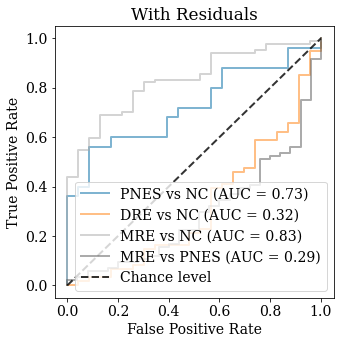

In [64]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy PSD (Black Box)

In [65]:
used_factors=np.arange(95)
sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['PNES_vs_all'].values
y_pnes, probs_pnes = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_pnes["y_psd_nn"] = y_pnes
all_pnes["probs_psd_nn"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_pnes,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['DRE_vs_all'].values
y_dre, probs_dre = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_dre["y_psd_nn"] = y_dre
all_dre["probs_psd_nn"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(y_dre,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_dre,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre, probs_mre = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_mre["y_psd_nn"] = y_mre
all_mre["probs_psd_nn"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(y_mre,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MRE_vs_all'].values
y_mre_pnes, probs_mre_pnes = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
all_mre_pnes["y_psd_nn"] = y_mre_pnes
all_mre_pnes["probs_psd_nn"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mre_pnes,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.73)
# PNES vs NC (Bal. ACC = 0.74)

# DRE vs NC (ACC = 0.45)
# DRE vs NC (Bal. ACC = 0.56)

# MRE vs NC (ACC = 0.78)
# MRE vs NC (Bal. ACC = 0.67)

# MRE vs PNES (ACC = 0.52)
# MRE vs PNES (Bal. ACC = 0.52)


/tmp/ipykernel_2233240/3209370604.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==1)]


AUC Mean: 0.6166666666666667
AUC Std: 0.45521667612492206
PNES vs NC (ACC = 0.71)
PNES vs NC (Bal. ACC = 0.71)
AUC Mean: 0.5833333333333334
AUC Std: 0.2838231060987733
DRE vs NC (ACC = 0.70)
DRE vs NC (Bal. ACC = 0.59)


/tmp/ipykernel_2233240/3209370604.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==2)]
/tmp/ipykernel_2233240/3209370604.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==0) | (epilepsy_df['Epilepsy']==3)]


AUC Mean: 0.5544444444444444
AUC Std: 0.3717061098485811
MRE vs NC (ACC = 0.68)
MRE vs NC (Bal. ACC = 0.56)


/tmp/ipykernel_2233240/3209370604.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= epilepsy_psds[(epilepsy_df['Epilepsy']==1) | (epilepsy_df['Epilepsy']==3)]


AUC Mean: 0.4744444444444444
AUC Std: 0.3293577738719348
MRE vs PNES (ACC = 0.67)
MRE vs PNES (Bal. ACC = 0.67)


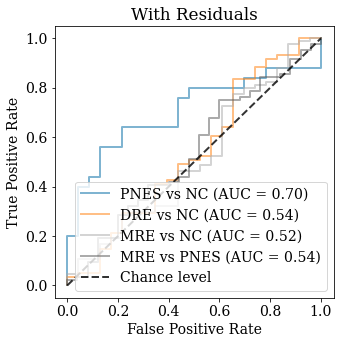

In [66]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy SL

In [67]:
from copy import deepcopy
import numpy as np
import pandas as pd
embeddings = np.load("/home/teja/tensor_decomposition_new/saved_embeddings/57f14ebfacd34476ad20000ecdd52c54_td.embeddings.npy")
epi_dx = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["epi_dx"]
subject_ids = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["subject_id"]
subject_ids = subject_ids[epi_dx>=0]
epilepsy_embeddings = embeddings[epi_dx>=0]
epi_dx = epi_dx[epi_dx>=0]
pnes_vs_all = (epi_dx==1).astype(int)
dre_vs_all = (epi_dx==2).astype(int)
mre_vs_all = (epi_dx==3).astype(int)

def create_mask(subject_labels,ids):
    mask = (subject_labels == ids[0])
    
    for i in range(1,len(ids)):
        mask = mask | (subject_labels == ids[i])
    return mask
    
def classify_LOO_1(features, labels, subject_ids,clf= GaussianNB(), adjust_sampling_weight=False, folds=15, save_model=False, save_model_name="None"):

    clfs=[]
    unique_subject_ids = np.unique(subject_ids)
    unique_labels=[]
    for id_ in unique_subject_ids:
        unique_labels.append(np.mean(labels[subject_ids == id_ ]))
    unique_labels = np.array(unique_labels)
        
    kf = StratifiedKFold(folds)

    all_y = []
    all_probs=[]
    auc_scores=[]

    for train,test in kf.split(unique_subject_ids,unique_labels):
        train_mask = create_mask(subject_ids, unique_subject_ids[train])
        test_mask =  create_mask(subject_ids, unique_subject_ids[test])
        if adjust_sampling_weight:
            sampling_dict = {0:1./np.sum(labels[train_mask]==0), 1:1./np.sum(labels[train_mask]==1)}
            sample_weight = sklearn.utils.class_weight.compute_sample_weight(sampling_dict, labels[train_mask])
            fit_model = clf.fit(features[train_mask], labels[train_mask], sample_weight=sample_weight)
            clfs.append(deepcopy(fit_model))
        else:
            fit_model = clf.fit(features[train_mask], labels[train_mask])
            clfs.append(deepcopy(fit_model))
        test_y=[]
        test_probs=[]
        for subject_id in unique_subject_ids[test]:
            all_y.append(unique_labels[unique_subject_ids == subject_id])
            all_probs.append(np.mean(fit_model.predict_proba(features[subject_ids == subject_id])[:,1]))
            test_y.append(unique_labels[unique_subject_ids == subject_id])
            test_probs.append(np.mean(fit_model.predict_proba(features[subject_ids == subject_id])[:,1]))
#         print(test_y)
#         print(test_probs)
        auc_scores.append(roc_auc_score(test_y,test_probs))
    print("AUC Mean:",np.mean(auc_scores))
    print("AUC Std:",np.std(auc_scores))
    all_y = np.array(all_y).astype(int)
    all_probs = np.array(all_probs)
    if save_model:
        model_path = os.path.join(MODEL_DIR,save_model_name)
        with open(model_path,'wb') as f:
            pickle.dump(clfs,f)
    
    return all_y, all_probs

(2370, 2)


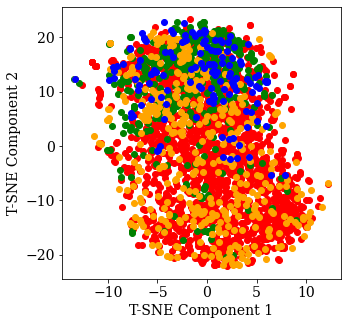

In [68]:
sub_embeddings=epilepsy_embeddings
sub_epi= epi_dx
epi_titles=['NC', 'PNES', 'DRE', 'MRE']

MAPPING_DIMENSION = 2
PERPLEXITY = 100
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=0,
                n_iter=EPOCHS
            ).fit_transform(sub_embeddings)
print(subset_z_embed.shape)
colors=["blue", "orange", "green", "red"]
for i in range(3,-1, -1):
    sub=subset_z_embed[sub_epi==i,:]
    plt.scatter(sub[:,0],sub[:,1],label=epi_titles[i], color=colors[i])
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
#plt.legend()
plt.show()

## Epilepsy SL (Gaussian Naive Bayes)

In [69]:
sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==1)]
sub_labels= pnes_vs_all[(epi_dx==0)|(epi_dx==1)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_pnes, probs_pnes = classify_LOO_1(features, labels,sub_ids, adjust_sampling_weight=True)
labels=y_pnes
all_pnes["y_sl_gb"] = y_pnes
all_pnes["probs_sl_gb"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(labels,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==2)]
sub_labels= dre_vs_all[(epi_dx==0)|(epi_dx==2)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==2)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_dre, probs_dre = classify_LOO_1(features, labels,sub_ids, adjust_sampling_weight=True)
labels=y_dre
all_dre["y_sl_gb"] = y_dre
all_dre["probs_sl_gb"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(labels,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==0)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre, probs_mre = classify_LOO_1(features, labels,sub_ids)
labels=y_mre
all_mre["y_sl_gb"] = y_mre
all_mre["probs_sl_gb"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(labels,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==1)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==1)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==1)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre_pnes, probs_mre_pnes = classify_LOO_1(features, labels,sub_ids)
labels=y_mre_pnes
all_mre_pnes["y_sl_gb"] = y_mre_pnes
all_mre_pnes["probs_sl_gb"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.75)
# PNES vs NC (Bal. ACC = 0.75)
# DRE vs NC (ACC = 0.36)
# DRE vs NC (Bal. ACC = 0.56)
# MRE vs NC (ACC = 0.69)
# MRE vs NC (Bal. ACC = 0.76)
# MRE vs PNES (ACC = 0.61)
# MRE vs PNES (Bal. ACC = 0.61)

AUC Mean: 0.75
AUC Std: 0.3535533905932738
PNES vs NC (ACC = 0.75)
PNES vs NC (Bal. ACC = 0.75)
AUC Mean: 0.5233333333333333
AUC Std: 0.3386820862631437
DRE vs NC (ACC = 0.36)
DRE vs NC (Bal. ACC = 0.56)
AUC Mean: 0.7300000000000001
AUC Std: 0.21310751937652228
MRE vs NC (ACC = 0.69)
MRE vs NC (Bal. ACC = 0.76)
AUC Mean: 0.5555555555555556
AUC Std: 0.2763295581210198
MRE vs PNES (ACC = 0.61)
MRE vs PNES (Bal. ACC = 0.61)


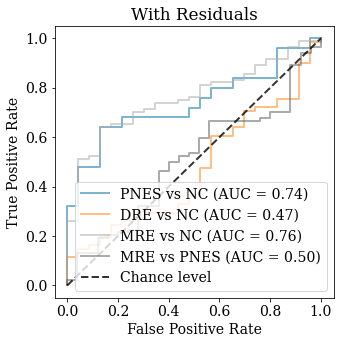

In [70]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy SL (Classical Machine Learning)

In [71]:
sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==1)]
sub_labels= pnes_vs_all[(epi_dx==0)|(epi_dx==1)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_pnes, probs_pnes = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"))
labels=y_pnes
all_pnes["y_sl_svm"] = y_pnes
all_pnes["probs_sl_svm"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(labels,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==2)]
sub_labels= dre_vs_all[(epi_dx==0)|(epi_dx==2)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==2)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_dre, probs_dre = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"))
labels=y_dre
all_dre["y_sl_svm"] = y_dre
all_dre["probs_sl_svm"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(labels,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==0)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre, probs_mre = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"))
labels=y_mre
all_mre["y_sl_svm"] = y_mre
all_mre["probs_sl_svm"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(labels,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==1)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==1)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==1)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre_pnes, probs_mre_pnes = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"))
labels=y_mre_pnes
all_mre_pnes["y_sl_svm"] = y_mre_pnes
all_mre_pnes["probs_sl_svm"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.75)
# PNES vs NC (Bal. ACC = 0.75)
# DRE vs NC (ACC = 0.39)
# DRE vs NC (Bal. ACC = 0.55)
# MRE vs NC (ACC = 0.81)
# MRE vs NC (Bal. ACC = 0.79)
# MRE vs PNES (ACC = 0.65)
# MRE vs PNES (Bal. ACC = 0.65)

AUC Mean: 0.8
AUC Std: 0.26140645235596877
PNES vs NC (ACC = 0.77)
PNES vs NC (Bal. ACC = 0.77)
AUC Mean: 0.5666666666666667
AUC Std: 0.27335365778094545
DRE vs NC (ACC = 0.50)
DRE vs NC (Bal. ACC = 0.56)
AUC Mean: 0.7522222222222222
AUC Std: 0.2568229442463388
MRE vs NC (ACC = 0.76)
MRE vs NC (Bal. ACC = 0.78)
AUC Mean: 0.5533333333333333
AUC Std: 0.2968476351910497
MRE vs PNES (ACC = 0.64)
MRE vs PNES (Bal. ACC = 0.64)


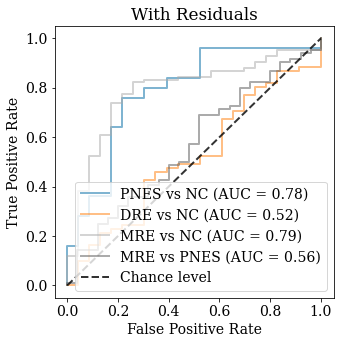

In [72]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy SL (Black Box)

In [73]:
sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==1)]
sub_labels= pnes_vs_all[(epi_dx==0)|(epi_dx==1)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_pnes, probs_pnes = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
labels=y_pnes
all_pnes["y_sl_nn"] = y_pnes
all_pnes["probs_sl_nn"] = probs_pnes
thres = sensivity_specifity_cutoff(y_pnes, probs_pnes)
acc=accuracy_score(labels,(probs_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_pnes>=thres).astype(int))
print("PNES vs NC (ACC = %0.2f)"%(acc))
print("PNES vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==2)]
sub_labels= dre_vs_all[(epi_dx==0)|(epi_dx==2)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==2)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_dre, probs_dre = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
labels=y_dre
all_dre["y_sl_nn"] = y_dre
all_dre["probs_sl_nn"] = probs_dre
thres = sensivity_specifity_cutoff(y_dre, probs_dre)
acc=accuracy_score(labels,(probs_dre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_dre>=thres).astype(int))
print("DRE vs NC (ACC = %0.2f)"%(acc))
print("DRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==0)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==0)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==0)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre, probs_mre = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
labels=y_mre
all_mre["y_sl_nn"] = y_mre
all_mre["probs_sl_nn"] = probs_mre
thres = sensivity_specifity_cutoff(y_mre, probs_mre)
acc=accuracy_score(labels,(probs_mre>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre>=thres).astype(int))
print("MRE vs NC (ACC = %0.2f)"%(acc))
print("MRE vs NC (Bal. ACC = %0.2f)"%(bal_acc))

sub_embeddings = epilepsy_embeddings[(epi_dx==1)|(epi_dx==3)]
sub_labels= mre_vs_all[(epi_dx==1)|(epi_dx==3)]
sub_ids= subject_ids[(epi_dx==1)|(epi_dx==3)]
features = sub_embeddings
labels = sub_labels
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mre_pnes, probs_mre_pnes = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))
labels=y_mre_pnes
all_mre_pnes["y_sl_nn"] = y_mre_pnes
all_mre_pnes["probs_sl_nn"] = probs_mre_pnes
thres = sensivity_specifity_cutoff(y_mre_pnes, probs_mre_pnes)
acc=accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mre_pnes>=thres).astype(int))
print("MRE vs PNES (ACC = %0.2f)"%(acc))
print("MRE vs PNES (Bal. ACC = %0.2f)"%(acc))

# PNES vs NC (ACC = 0.71)
# PNES vs NC (Bal. ACC = 0.71)
# DRE vs NC (ACC = 0.58)
# DRE vs NC (Bal. ACC = 0.52)
# MRE vs NC (ACC = 0.68)
# MRE vs NC (Bal. ACC = 0.73)
# MRE vs PNES (ACC = 0.36)
# MRE vs PNES (Bal. ACC = 0.36)

AUC Mean: 0.8
AUC Std: 0.29154759474226505
PNES vs NC (ACC = 0.73)
PNES vs NC (Bal. ACC = 0.72)
AUC Mean: 0.5633333333333332
AUC Std: 0.24560582693051525
DRE vs NC (ACC = 0.50)
DRE vs NC (Bal. ACC = 0.57)
AUC Mean: 0.6322222222222221
AUC Std: 0.2827423029483618
MRE vs NC (ACC = 0.64)
MRE vs NC (Bal. ACC = 0.74)
AUC Mean: 0.45222222222222225
AUC Std: 0.272088402482414
MRE vs PNES (ACC = 0.71)
MRE vs PNES (Bal. ACC = 0.71)


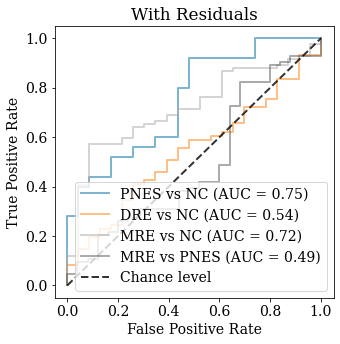

In [74]:
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='PNES vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_pnes, probs_pnes)
# print("PNES vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='DRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_dre, probs_dre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs NC (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre, probs_mre)
# print("DRE vs NC (ACC = %0.2f)"%(acc))
fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MRE vs PNES (AUC = %0.2f)' % (roc_auc))
# acc=accuracy_score(y_mre_pnes, probs_mre_pnes)
# print("MRE vs PNES (ACC = %0.2f)"%(acc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Epilepsy (Plot all representations)

In [75]:
# #Plot all pnes vs all
# fig, ax = plt.subplots(1,1)
# pnes_vs_all_keys = list(all_pnes.keys())
# pnes_vs_all_keys.sort()
# pnes_prob_keys = pnes_vs_all_keys[:len(pnes_vs_all_keys)//2]
# pnes_y_keys = pnes_vs_all_keys[len(pnes_vs_all_keys)//2:] 
# pnes_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(pnes_prob_keys)):
#     y_pnes = all_pnes[pnes_y_keys[i]]
#     probs_pnes = all_pnes[pnes_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_pnes, probs_pnes)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{pnes_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('PNES vs NC')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show()    

In [76]:
# #Plot all dre vs all
# fig, ax = plt.subplots(1,1)
# dre_vs_all_keys = list(all_dre.keys())
# dre_vs_all_keys.sort()
# dre_prob_keys = dre_vs_all_keys[:len(dre_vs_all_keys)//2]
# dre_y_keys = dre_vs_all_keys[len(dre_vs_all_keys)//2:] 
# dre_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(dre_prob_keys)):
#     y_dre = all_dre[dre_y_keys[i]]
#     probs_dre = all_dre[dre_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_dre, probs_dre)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{pnes_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('DRE vs NC')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show() 

In [77]:
# #Plot all dre vs all
# fig, ax = plt.subplots(1,1)
# mre_vs_all_keys = list(all_mre.keys())
# mre_vs_all_keys.sort()
# mre_prob_keys = mre_vs_all_keys[:len(mre_vs_all_keys)//2]
# mre_y_keys = mre_vs_all_keys[len(mre_vs_all_keys)//2:] 
# mre_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(mre_prob_keys)):
#     y_mre = all_mre[mre_y_keys[i]]
#     probs_mre = all_mre[mre_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_mre, probs_mre)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{pnes_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('MRE vs NC')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show() 

In [78]:
# #Plot all dre vs all
# fig, ax = plt.subplots(1,1)
# mre_pnes_vs_all_keys = list(all_mre_pnes.keys())
# mre_pnes_vs_all_keys.sort()
# mre_pnes_prob_keys = mre_pnes_vs_all_keys[:len(mre_pnes_vs_all_keys)//2]
# mre_pnes_y_keys = mre_pnes_vs_all_keys[len(mre_pnes_vs_all_keys)//2:] 
# mre_pnes_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(mre_pnes_prob_keys)):
#     y_mre_pnes = all_mre_pnes[mre_pnes_y_keys[i]]
#     probs_mre_pnes = all_mre_pnes[mre_pnes_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_mre_pnes, probs_mre_pnes)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{mre_pnes_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('MRE vs PNES')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show() 

### AD

In [79]:
ad_df = cls_df.copy()[cls_df['Alzheimers']>=0]

ad_df['MCI_vs_all'] = (ad_df['Alzheimers'] == 1).astype(int)
ad_df['AD_vs_all'] = (ad_df['Alzheimers'] == 2).astype(int)
#print(len(band_pows))
all_ad={}
all_mci={}

## AD TD Naive Bayes

In [80]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="td_gnb_mci" )
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="td_gnb_ad" )
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.56)
# MCI vs CN (Bal. ACC: 0.55)
# AD vs CN (ACC: 0.77)
# AD vs CN (Bal. ACC: 0.76)

AUC Mean: 0.65
AUC Std: 0.32659863237109044
MCI vs CN (ACC: 0.62)
MCI vs CN (Bal. ACC: 0.59)
AUC Mean: 0.8944444444444444
AUC Std: 0.1594744454934147
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


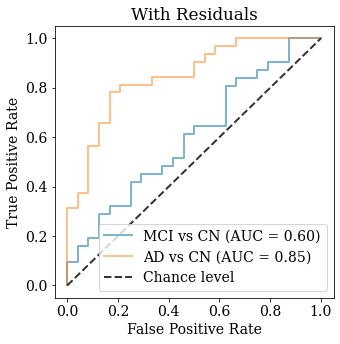

In [81]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## AD TD SVM

In [82]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))#, save_model=True, save_model_name="td_svm_mci" )
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"))#, save_model=True, save_model_name="td_svm_ad" )
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.64)
# MCI vs CN (Bal. ACC: 0.63)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.72)

AUC Mean: 0.5944444444444444
AUC Std: 0.3116067480528924
MCI vs CN (ACC: 0.55)
MCI vs CN (Bal. ACC: 0.54)
AUC Mean: 0.9166666666666666
AUC Std: 0.149071198499986
AD vs CN (ACC: 0.71)
AD vs CN (Bal. ACC: 0.72)


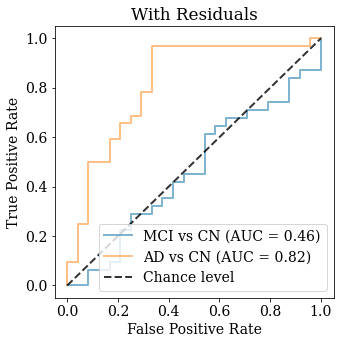

In [83]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## AD TD NN

In [84]:
used_factors = ['F1',
                'F2',
                'F3',
                #'F4',
                #'F5',
               ]

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['MCI_vs_all'].values
#labels = sub_df['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="td_nn_mci")
all_mci["y_td_gb"]=y_mci
all_mci["probs_td_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_df = ad_df[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_df.groupby(['PID']).mean()[used_factors].values
#features = sub_df[used_factors].values
labels = sub_df.groupby(['PID']).mean()['AD_vs_all'].values
#labels = sub_df['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="td_nn_ad")
all_ad["y_td_gb"]=y_ad
all_ad["probs_td_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.53)
# MCI vs CN (Bal. ACC: 0.52)
# AD vs CN (ACC: 0.57)
# AD vs CN (Bal. ACC: 0.54)

AUC Mean: 0.4611111111111111
AUC Std: 0.31011746082117475
MCI vs CN (ACC: 0.56)
MCI vs CN (Bal. ACC: 0.54)
AUC Mean: 0.6333333333333333
AUC Std: 0.3453393392871123
AD vs CN (ACC: 0.57)
AD vs CN (Bal. ACC: 0.60)


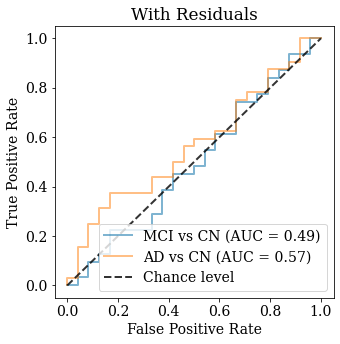

In [85]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSDS

In [86]:
ad_psds= band_pows.copy()[cls_df['Alzheimers']>=0]
print(ad_psds)
ad_psds['PID']= ad_df['PID']
ad_psds['MCI_vs_all']= (ad_df['Alzheimers'] == 1).astype(int)
ad_psds['AD_vs_all']= (ad_df['Alzheimers'] == 2).astype(int)

              0         1         2         3         4         5         6  \
1158   0.450674  0.092478  0.415323  0.084468  0.256064  0.168071  0.384812   
1159   0.203087  0.029720  0.226063  0.072452  0.145875  0.094862  0.088078   
1160   0.163220  0.434837  0.239071  0.120859  0.174741  0.148661  0.149105   
1161   0.308965  0.054585  0.357325  0.072603  0.169394  0.105995  0.089845   
1162   0.589777  0.188518  0.220984  0.158756  0.454637  0.163099  0.255631   
...         ...       ...       ...       ...       ...       ...       ...   
17035  0.074482  0.048392  0.432896  0.246360  0.372832  0.218223  0.193649   
17036  0.042809  0.015300  0.098415  0.073495  0.090775  0.053098  0.109239   
17037  0.029230  0.019218  0.196782  0.114350  0.172197  0.090779  0.097888   
17038  0.022071  0.027383  0.258494  0.119278  0.225789  0.081705  0.096678   
17039  0.139541  0.084387  0.271915  0.158794  0.149705  0.121134  0.067866   

              7         8         9  ...        86 

/tmp/ipykernel_2233240/615431065.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ad_psds= band_pows.copy()[cls_df['Alzheimers']>=0]


/tmp/ipykernel_2233240/799079087.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_band_pows= band_pows[cls_df["Alzheimers"]>=0]


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 630 samples in 0.000s...
[t-SNE] Computed neighbors for 630 samples in 0.263s...
[t-SNE] Computed conditional probabilities for sample 630 / 630
[t-SNE] Mean sigma: 0.445068
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 71.1333084, gradient norm = 0.4865181 (50 iterations in 0.211s)
[t-SNE] Iteration 100: error = 69.9563828, gradient norm = 0.4867163 (50 iterations in 0.114s)
[t-SNE] Iteration 150: error = 70.6058273, gradient norm = 0.4660225 (50 iterations in 0.083s)
[t-SNE] Iteration 200: error = 70.5508804, gradient norm = 0.4742842 (50 iterations in 0.081s)
[t-SNE] Iteration 250: error = 70.2831421, gradient norm = 0.4785971 (50 iterations in 0.053s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.283142
[t-SNE] Iteration 300: error = 0.8616117, gradient norm = 0.0022719 (50 iterations in 0.218s)
[t-SNE] Iteration 350: error = 0.7127241, gradient norm = 0.0006043 (

Text(0, 0.5, 'TSNE Factor 2')

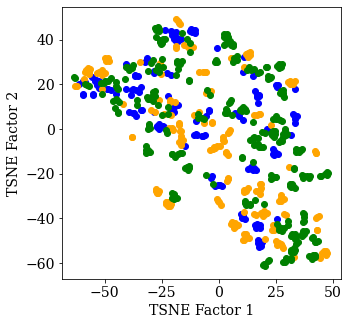

In [87]:
MAPPING_DIMENSION = 2
PERPLEXITY = 15
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
sub_band_pows= band_pows[cls_df["Alzheimers"]>=0]
sub_band_pows=sub_band_pows.astype(np.float64)
sub_band_pows[np.isnan(sub_band_pows)]=0
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=3,
                n_iter=EPOCHS
            ).fit_transform(sub_band_pows)
print(subset_z_embed.shape)
alz_titles=['CN', 'MCI', 'AD']
colors=["blue","orange","green"]
for i in range(3):
    sub= subset_z_embed[ad_df["Alzheimers"]==i]
    plt.scatter(sub[:,0],sub[:,1],label=alz_titles[i], color=colors[i])
plt.xlabel("TSNE Factor 1")
plt.ylabel("TSNE Factor 2")
#plt.legend(loc="lower right")

Text(0, 0.5, 'TSNE Factor 2')

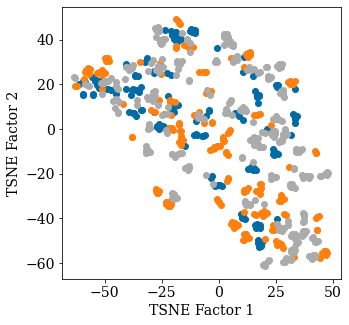

In [88]:
alz_titles=['CN', 'MCI', 'AD']
for i in range(3):
    sub= subset_z_embed[ad_df["Alzheimers"]==i]
    plt.scatter(sub[:,0],sub[:,1],label=alz_titles[i])
plt.xlabel("TSNE Factor 1")
plt.ylabel("TSNE Factor 2")
#plt.legend(loc="upper right")

## Alzheimers PSDS (Gaussian Naive Bayes)

In [89]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="psd_gnb_mci")
all_mci["y_psd_gb"]=y_mci
all_mci["probs_psd_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="psd_gnb_ad")
all_ad["y_psd_gb"]=y_ad
all_ad["probs_psd_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.55)
# MCI vs CN (Bal. ACC: 0.59)
# AD vs CN (ACC: 0.86)
# AD vs CN (Bal. ACC: 0.85)

AUC Mean: 0.4944444444444444
AUC Std: 0.38425814368423516
MCI vs CN (ACC: 0.53)
MCI vs CN (Bal. ACC: 0.57)
AUC Mean: 0.9166666666666666
AUC Std: 0.149071198499986
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


/tmp/ipykernel_2233240/1288872897.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
/tmp/ipykernel_2233240/1288872897.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


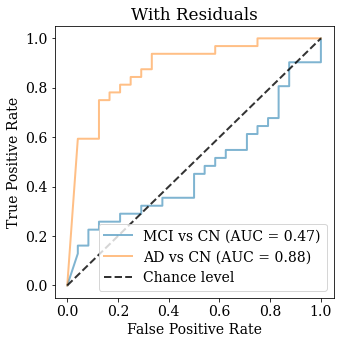

In [90]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSD (Classical Machine Learning)

In [91]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="psd_svm_mci")
all_mci["y_psd_svm"]=y_mci
all_mci["probs_psd_svm"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="psd_svm_ad")
all_ad["y_psd_svm"]=y_ad
all_ad["probs_psd_svm"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad, (probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad, (probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.67)
# MCI vs CN (Bal. ACC: 0.65)
# AD vs CN (ACC: 0.80)
# AD vs CN (Bal. ACC: 0.81)

AUC Mean: 0.65
AUC Std: 0.3511884584284246
MCI vs CN (ACC: 0.65)
MCI vs CN (Bal. ACC: 0.63)
AUC Mean: 0.861111111111111
AUC Std: 0.18425693279752223
AD vs CN (ACC: 0.80)
AD vs CN (Bal. ACC: 0.81)


/tmp/ipykernel_2233240/3571102360.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
/tmp/ipykernel_2233240/3571102360.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


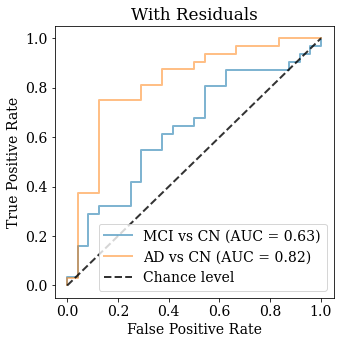

In [92]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimers PSD (Neural Network)

In [93]:
used_factors=np.arange(95)
sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['MCI_vs_all'].values
y_mci, probs_mci = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="psd_nn_mci")
all_mci["y_psd_nn"]=y_mci
all_mci["probs_psd_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(y_mci,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_mci,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]
features = sub_psds.groupby(['PID']).mean()[used_factors].values
labels = sub_psds.groupby(['PID']).mean()['AD_vs_all'].values
y_ad, probs_ad = classify_Strat(features, labels, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True), save_model=True, save_model_name="psd_nn_ad")
all_ad["y_psd_nn"]=y_mci
all_ad["probs_psd_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(y_ad,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(y_ad,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.56)
# MCI vs CN (Bal. ACC: 0.57)

# AD vs CN (ACC: 0.75)
# AD vs CN (Bal. ACC: 0.77)


/tmp/ipykernel_2233240/1282302211.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==1)]


AUC Mean: 0.42777777777777776
AUC Std: 0.3303570832737445
MCI vs CN (ACC: 0.53)
MCI vs CN (Bal. ACC: 0.57)


/tmp/ipykernel_2233240/1282302211.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_psds= ad_psds[(ad_df['Alzheimers']==0) | (ad_df['Alzheimers']==2)]


AUC Mean: 0.8333333333333334
AUC Std: 0.21730674684008833
AD vs CN (ACC: 0.79)
AD vs CN (Bal. ACC: 0.79)


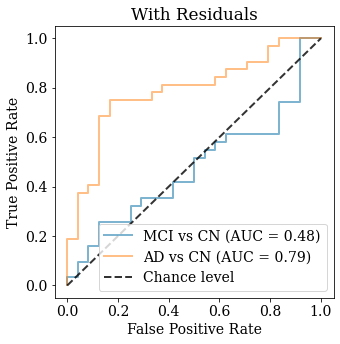

In [94]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL

In [95]:
import numpy as np
import pandas as pd
embeddings = np.load("/home/teja/tensor_decomposition_new/saved_embeddings/57f14ebfacd34476ad20000ecdd52c54_td.embeddings.npy")
alz_dx = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["alz_dx"]
subject_ids = pd.read_csv("/home/teja/tensor_decomposition_new/metadata/td_index1.csv")["subject_id"]
subject_ids = subject_ids[alz_dx>=0]
alz_embeddings = embeddings[alz_dx>=0]
alz_dx = alz_dx[alz_dx>=0]
mci_vs_all = (alz_dx==1).astype(int)
ad_vs_all = (alz_dx==2).astype(int)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 630 samples in 0.001s...
[t-SNE] Computed neighbors for 630 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 630 / 630
[t-SNE] Mean sigma: 1.459711
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 80.2286758, gradient norm = 0.4628496 (50 iterations in 0.275s)
[t-SNE] Iteration 100: error = 81.4755936, gradient norm = 0.4487084 (50 iterations in 0.059s)
[t-SNE] Iteration 150: error = 79.7094574, gradient norm = 0.4690073 (50 iterations in 0.084s)
[t-SNE] Iteration 200: error = 79.8956375, gradient norm = 0.4819632 (50 iterations in 0.134s)
[t-SNE] Iteration 250: error = 80.8504562, gradient norm = 0.4787258 (50 iterations in 0.057s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.850456
[t-SNE] Iteration 300: error = 1.5331273, gradient norm = 0.0039936 (50 iterations in 0.181s)
[t-SNE] Iteration 350: error = 1.3888956, gradient norm = 0.0013532 (

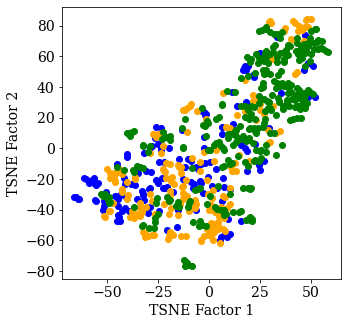

In [96]:
sub_embeddings=alz_embeddings
sub_alz= alz_dx
alz_titles=["CN","MCI","AD"]

MAPPING_DIMENSION = 2
PERPLEXITY = 10
EPOCHS = 3000
METHOD = "barnes_hut"
from sklearn.manifold import TSNE
subset_z_embed = TSNE(
                n_components=MAPPING_DIMENSION,
                perplexity=PERPLEXITY,
                method=METHOD,
                n_jobs=24,
                verbose=3,
                n_iter=EPOCHS
            ).fit_transform(sub_embeddings)
print(subset_z_embed.shape)
colors = ["blue","orange","green"]
for i in range(3):
    sub=subset_z_embed[sub_alz==i,:]
    plt.scatter(sub[:,0],sub[:,1],label=alz_titles[i], color=colors[i])
plt.xlabel("TSNE Factor 1")
plt.ylabel("TSNE Factor 2")
#plt.legend()
plt.show()

## Alzheimer's SL (Gaussian Naive Bayes)

In [97]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="ssl_gnb_mci")
# print(y_mci)
# print(probs_mci)
labels=y_mci
all_mci["y_sl_gb"]=y_mci
all_mci["probs_sl_gb"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, adjust_sampling_weight=True, clf=GaussianNB(var_smoothing=0.1), save_model=True, save_model_name="ssl_gnb_ad")
labels=y_ad
all_ad["y_sl_gb"]=y_ad
all_ad["probs_sl_gb"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.49)
# MCI vs CN (Bal. ACC: 0.53)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.75)

AUC Mean: 0.45
AUC Std: 0.4
MCI vs CN (ACC: 0.51)
MCI vs CN (Bal. ACC: 0.55)
AUC Mean: 0.6944444444444445
AUC Std: 0.33147630867058436
AD vs CN (ACC: 0.71)
AD vs CN (Bal. ACC: 0.73)


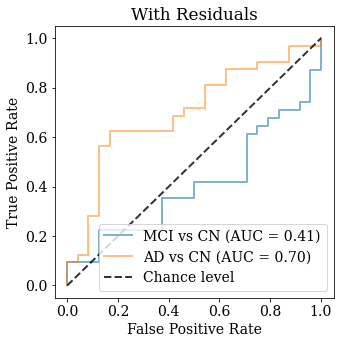

In [98]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL (Classical Machine Learning)

In [99]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="ssl_svm_mci")
labels=y_mci
all_mci["y_sl_svm"]=y_mci
all_mci["probs_sl_svm"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, clf=SVC(probability=True, class_weight="balanced"), save_model=True, save_model_name="ssl_svm_ad")
labels=y_ad
all_ad["y_sl_svm"]=y_ad
all_ad["probs_sl_svm"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.58)
# MCI vs CN (Bal. ACC: 0.56)
# AD vs CN (ACC: 0.68)
# AD vs CN (Bal. ACC: 0.70)

AUC Mean: 0.5277777777777778
AUC Std: 0.3491612524993482
MCI vs CN (ACC: 0.56)
MCI vs CN (Bal. ACC: 0.56)
AUC Mean: 0.6666666666666666
AUC Std: 0.2755465948363832
AD vs CN (ACC: 0.68)
AD vs CN (Bal. ACC: 0.70)


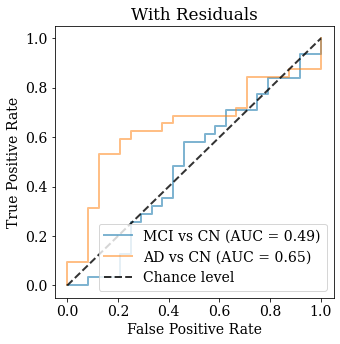

In [100]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## Alzheimer's SL (Neural Network)

In [101]:
sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==1)]
sub_labels= mci_vs_all[(alz_dx==0)|(alz_dx==1)]
print(len(subject_ids), len(alz_dx))
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==1)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_mci, probs_mci = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,), max_iter=100000, early_stopping=True))#, save_model=True, save_model_name="ssl_nn_mci")
labels=y_mci
all_mci["y_sl_nn"]=y_mci
all_mci["probs_sl_nn"]= probs_mci
thres = sensivity_specifity_cutoff(y_mci, probs_mci)
acc = accuracy_score(labels,(probs_mci>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_mci>=thres).astype(int))
print("MCI vs CN (ACC: %0.2f)"%(acc))
print("MCI vs CN (Bal. ACC: %0.2f)"%(bal_acc))

sub_embeddings = alz_embeddings[(alz_dx==0)|(alz_dx==2)]
sub_labels= ad_vs_all[(alz_dx==0)|(alz_dx==2)]
sub_ids= subject_ids[(alz_dx==0)|(alz_dx==2)]
features = sub_embeddings
labels = sub_labels
# for subject_id in sub_ids:
#     features.append(np.mean(sub_embeddings[sub_ids==subject_id],axis=0))
#     labels.append(np.mean(sub_labels[sub_ids==subject_id],axis=0))
features= np.vstack(features)
labels=np.hstack(labels).astype(int)
y_ad, probs_ad = classify_LOO_1(features, labels,sub_ids, clf=MLPClassifier(hidden_layer_sizes=(200,),max_iter=100000, early_stopping=True))#, save_model=True, save_model_name="ssl_nn_ad")
labels=y_ad
all_ad["y_sl_nn"]=y_ad
all_ad["probs_sl_nn"]= probs_ad
thres = sensivity_specifity_cutoff(y_ad, probs_ad)
acc = accuracy_score(labels,(probs_ad>=thres).astype(int))
bal_acc = balanced_accuracy_score(labels,(probs_ad>=thres).astype(int))
print("AD vs CN (ACC: %0.2f)"%(acc))
print("AD vs CN (Bal. ACC: %0.2f)"%(bal_acc))

# MCI vs CN (ACC: 0.60)
# MCI vs CN (Bal. ACC: 0.60)
# AD vs CN (ACC: 0.73)
# AD vs CN (Bal. ACC: 0.73)

630 630
AUC Mean: 0.5944444444444444
AUC Std: 0.36115384362544456
MCI vs CN (ACC: 0.62)
MCI vs CN (Bal. ACC: 0.63)
AUC Mean: 0.6833333333333333
AUC Std: 0.2725055215206827
AD vs CN (ACC: 0.70)
AD vs CN (Bal. ACC: 0.72)


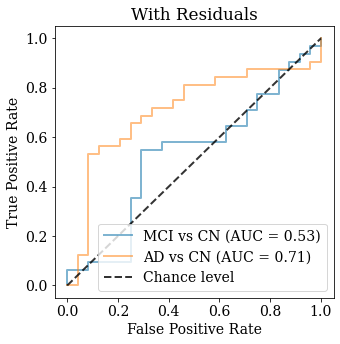

In [102]:
fig, ax = plt.subplots(1,1)

fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='MCI vs CN (AUC = %0.2f)' % (roc_auc))

fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=2, alpha=0.5, label='AD vs CN (AUC = %0.2f)' % (roc_auc))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('With Residuals')
ax.legend(loc="lower right")

plt.show()

## ALzheimer's (Plot All)

In [103]:
# #Plot all mci vs all
# fig, ax = plt.subplots(1,1)
# mci_vs_all_keys = list(all_mci.keys())
# mci_vs_all_keys.sort()
# mci_prob_keys = mci_vs_all_keys[:len(mci_vs_all_keys)//2]
# mci_y_keys = mci_vs_all_keys[len(mci_vs_all_keys)//2:] 
# mci_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(mci_prob_keys)):
#     y_mci = all_mci[mci_y_keys[i]]
#     probs_mci = all_mci[mci_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_mci, probs_mci)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{mci_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('MCI vs CN')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show() 

In [104]:
# #Plot all mci vs all
# fig, ax = plt.subplots(1,1)
# ad_vs_all_keys = list(all_ad.keys())
# ad_vs_all_keys.sort()
# ad_prob_keys = ad_vs_all_keys[:len(ad_vs_all_keys)//2]
# ad_y_keys = ad_vs_all_keys[len(ad_vs_all_keys)//2:] 
# ad_titles = ["PSD GNB", "PSD NN", "PSD SVM",
#               "SSL GNB", "SSL NN",
#               "SSL SVM", "TD GNB"]
# for i in range(len(ad_prob_keys)):
#     y_ad = all_ad[ad_y_keys[i]]
#     probs_ad = all_ad[ad_prob_keys[i]]
#     fpr, tpr, thresholds = roc_curve(y_ad, probs_ad)
#     roc_auc = auc(fpr, tpr)
#     ax.plot(fpr, tpr, lw=2, alpha=0.5, label= f'{mci_titles[i]} (AUC = %0.2f)' % (roc_auc))
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('AD vs CN')
# ax.legend(loc="lower right",prop={"size":10})

# plt.show() 

## TODO: rerun artifact analysis

## Artifact Analysis

In [105]:
full_psds1=np.load("/mnt/ssd_2tb_1/shared/TUH_ARTIFACTS_v2_PROCESSED/full_psds_absolute.npy")
trans_psds1 = (full_psds1 - psds_min) / (psds_max - psds_min)

In [106]:
df=pd.read_csv("/mnt/ssd_2tb_1/shared/TUH_ARTIFACTS_v2_PROCESSED/window_index_TUARv2.csv")
raw_file_paths=np.array(df["raw_file_path"])
artifact_type=np.array(df["artifact_type"])

In [107]:
def find_features(trans_psds,factors_tt):
    features=[]
    for i in range(trans_psds.shape[0]):
        x_test=trans_psds[i]
        x_test=x_test.reshape((-1,1))
        F=[]
        for j in range(factors_tt[0].shape[1]):
            f=np.outer(factors_tt[1][:,j],factors_tt[2][:,j])

            F.append(f.reshape((-1,1)))
        F=np.concatenate(F,axis=1)
        w=np.linalg.pinv(F)@x_test
        features.append(w.T)
    features=np.concatenate(features,axis=0)
    return features

In [108]:
artifact_factors=[find_features(trans_psds1,factors_orig),factors_orig[1],factors_orig[2]]

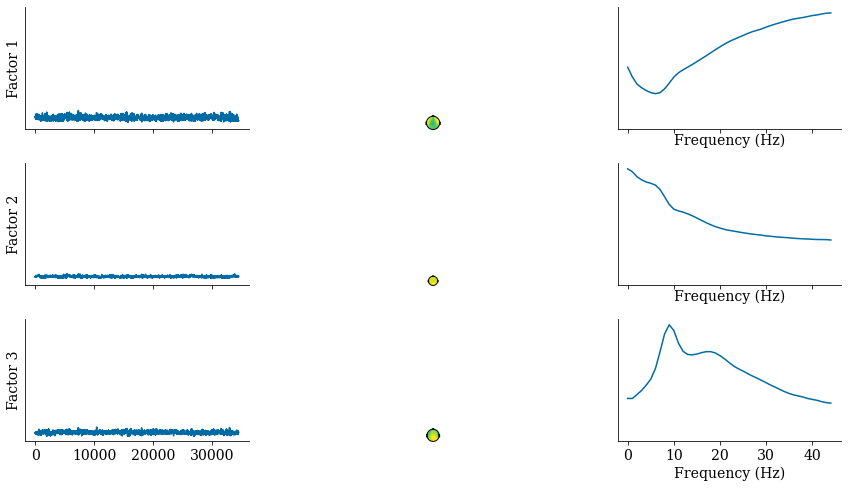

In [109]:
plot_factors(artifact_factors)

34453 (34453, 3)


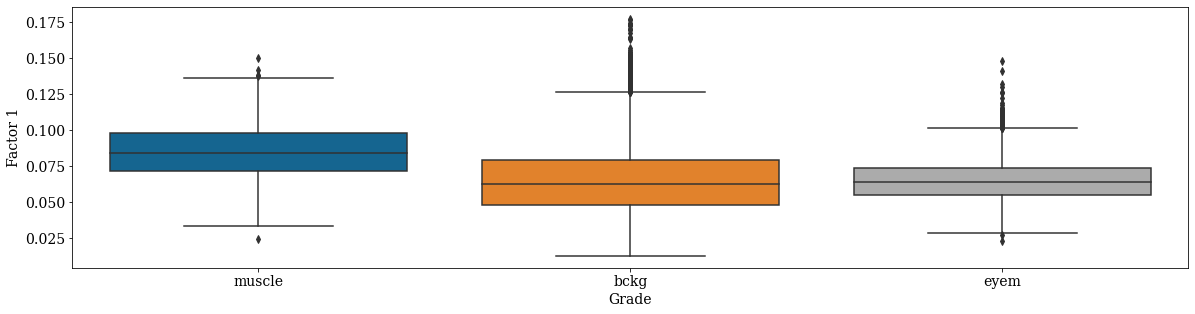

25699 1208 2870
ANOVA Test p-value: 6.964990437721764e-162
t-test background vs muscle p-value: 1.2323231751835123e-150
t-test background vs eye movement p-value: 0.018618091446373972


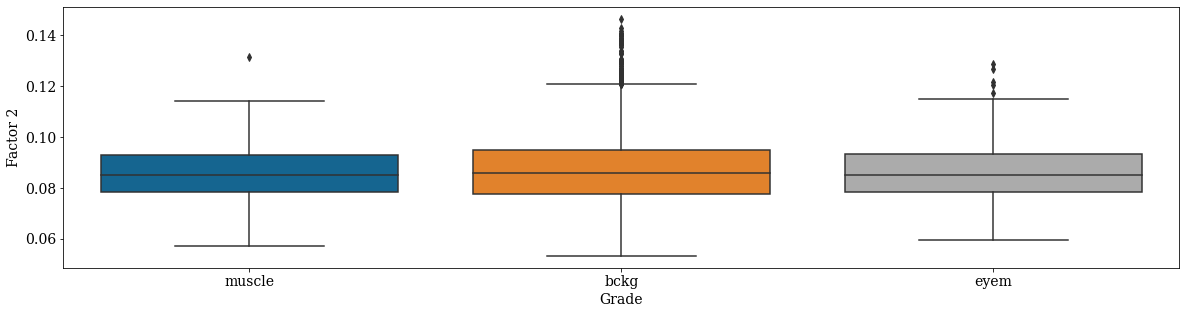

25699 1208 2870
ANOVA Test p-value: 0.1685922247714171
t-test background vs muscle p-value: 0.062025267736540206
t-test background vs eye movement p-value: 0.8114027889669231


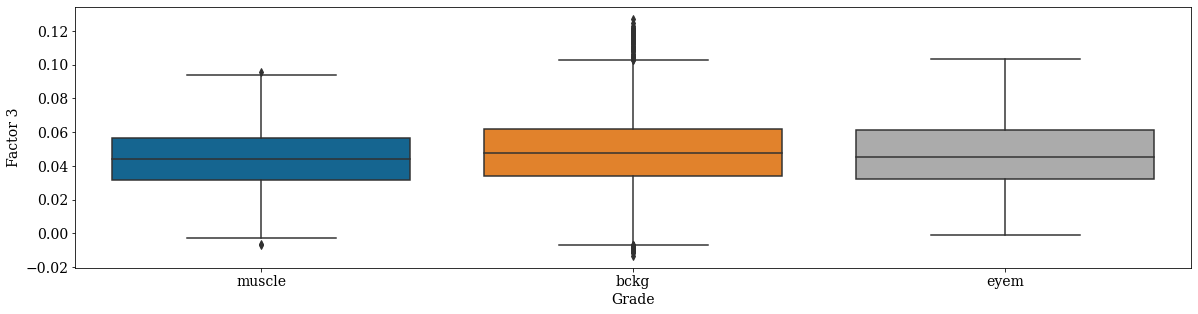

25699 1208 2870
ANOVA Test p-value: 6.627172127162808e-14
t-test background vs muscle p-value: 1.1662736980820223e-13
t-test background vs eye movement p-value: 0.005519008251819911


In [110]:
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
#fig, ax = plt.subplots(R,1,sharey=True,figsize=(20,40))
print(len(artifact_type),artifact_factors[0].shape)
artifact_type1 = artifact_type.astype(str)
submask = (artifact_type1 == "bckg") | (artifact_type1 == "chew") | (artifact_type1 == "musc") | (artifact_type1 == "shiv") | (artifact_type1 == "eyem")
sub_artifact_factors = artifact_factors[0][submask,...]
sub_artifact_type =  artifact_type1[submask]
sub_artifact_type[(sub_artifact_type == "chew")|(sub_artifact_type == "musc")|(sub_artifact_type == "shiv")]="muscle"
for i in range(R):
    fig, ax = plt.subplots(1,1,sharey=True,figsize=(20,4.8))
    x= sub_artifact_type
    y=sub_artifact_factors[:,i]
    sns.boxplot(x=x,y=y,ax=ax)
    ax.set_xlabel("Grade", {'fontsize' : 14})
    ax.set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
    plt.show()
    
    bckg = y[x=="bckg"]
    muscle = y[x=="muscle"]
    eyem = y[x=="eyem"]
    print(len(bckg),len(muscle),len(eyem))
    print("ANOVA Test p-value:",f_oneway(bckg,muscle,eyem).pvalue)
    print("t-test background vs muscle p-value:", ttest_ind(bckg,muscle).pvalue)
    print("t-test background vs eye movement p-value:",ttest_ind(bckg,eyem).pvalue)
#     sns.boxplot(x=x, y=y, ax=ax[i])
#     ax[i].set_xlabel("Grade", {'fontsize' : 14})
#     ax[i].set_ylabel("Factor %d"%(i+1), {'fontsize' : 14})
#plt.show()

In [111]:
from scipy.stats import ks_2samp
muscle_bckg=artifact_type[(artifact_type=="chew")|(artifact_type=="musc")|(artifact_type=="shiv")|(artifact_type=="bckg")]
muscle_features=artifact_factors[0][(artifact_type=="chew")|(artifact_type=="musc")|(artifact_type=="shiv")|(artifact_type=="bckg"),:]
muscle_bckg[muscle_bckg=="musc"]=1
muscle_bckg[muscle_bckg=="chew"]=1
muscle_bckg[muscle_bckg=="shiv"]=1
muscle_bckg[muscle_bckg=="bckg"]=0
muscle_bckg=muscle_bckg.astype(int)
for i in range(R):
    muscle_factor=artifact_factors[0][(artifact_type=="chew")|(artifact_type=="musc")|(artifact_type=="shiv"),i]
    bckg_factor=artifact_factors[0][(artifact_type=="bckg"),i]
    print(ttest_ind(muscle_factor,bckg_factor).pvalue)

1.2323231751835123e-150
0.062025267736540206
1.1662736980820223e-13


In [112]:
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,roc_auc_score
from tqdm import tqdm
clf=LogisticRegression()
scores = cross_val_score(clf,muscle_features, muscle_bckg, cv=10)
print(scores)
print(np.mean(scores))
scores = cross_val_score(clf,muscle_features, muscle_bckg, cv=10,scoring="roc_auc")
print(scores)
print(np.mean(scores))

[0.9550353  0.9550353  0.9550353  0.9550353  0.9550353  0.9550353
 0.9550353  0.95501859 0.95539033 0.95539033]
0.9551046376535304
[0.79864296 0.80139885 0.82348136 0.71806927 0.61148985 0.8162588
 0.70021867 0.72243437 0.65914721 0.7723476 ]
0.7423488941778501


In [113]:
np.unique(artifact_type.astype(str))

array(['bckg', 'chew', 'chew_elec', 'chew_musc', 'elec', 'elpp', 'eyem',
       'eyem_chew', 'eyem_elec', 'eyem_musc', 'musc', 'musc_elec', 'nan',
       'shiv'], dtype='<U9')